In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## 1. 배경/목적
- 앱내 특정화면에 업소를 노출하기 위한 랭킹 스코어 산출 & 지표 모니터링 및 고도화
- 최종적으로, 특정 서비스/기능의 유저 만족도를 측정하고 개선하기 위한 근거 마련

## 2. 분석 Frame
- **테이블 추출 및 전처리**
    - 테이블 추출 및 조인
    - 전처리
- **데이터 탐색 및 변수 이해**
    - 분포 확인 및 시각화
    - 선형 변환 및 신규 변수 생성
- **스코어 산출**
    - 가중치 부여 산정/협의
    - 스코어 계산
- **사전/사후 검증 및 지표 트래킹**
    - 사전 설문을 통한 검증
    - 실제 배포후 지표 모니터링
- **로직 설계 고도화**
    - 개인화 추천 (CF, MF, Contents-based)
    - 쿼터 지정
    - A/B Testing
    
![img](rank_framework.png)    

### Popularity

- 추출과정 생략

In [3]:
df = pd.read_csv("data_popularity.csv", index_col=0)

In [4]:
df.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
0,36235,관악구,2010-02-28,15.0,1.0,5.0,NaN,296.0,6.0,2.027,458000.0,30533.0,0.0,0.000,0.0,0.000
1,39647,성남시 분당구,2010-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,459193,관악구,2013-01-30,61.0,1.0,5.0,6.0,6938.0,156.0,2.248,1009200.0,16544.0,1.0,0.016,5.0,0.082
3,522695,강서구,2014-07-22,62.0,4.0,5.0,4.0,1739.0,27.0,1.553,1101000.0,17758.0,1.0,0.016,0.0,0.000
4,563770,송파구,2015-05-13,75.0,2.0,5.0,5.0,602.0,13.0,2.159,894000.0,11920.0,0.0,0.000,3.0,0.040


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3799 entries, 0 to 3798
Data columns (total 16 columns):
shop_no          3799 non-null int64
rgn2_nm          3799 non-null object
reg_dt           3799 non-null object
ord_cnt          2974 non-null float64
rvw_count        1386 non-null float64
star_pnt_mean    1386 non-null float64
fav_count        2611 non-null float64
imps_cnt         2828 non-null float64
clk_cnt          2828 non-null float64
ctr              2828 non-null float64
ord_price_sum    2381 non-null float64
ppo              2381 non-null float64
ord_cncl_cnt     2381 non-null float64
ord_cncl_rate    2381 non-null float64
reord_dvc_cnt    2381 non-null float64
reord_rate       2381 non-null float64
dtypes: float64(13), int64(1), object(2)
memory usage: 504.6+ KB


In [6]:
df.isnull().sum()

shop_no             0
rgn2_nm             0
reg_dt              0
ord_cnt           825
rvw_count        2413
star_pnt_mean    2413
fav_count        1188
imps_cnt          971
clk_cnt           971
ctr               971
ord_price_sum    1418
ppo              1418
ord_cncl_cnt     1418
ord_cncl_rate    1418
reord_dvc_cnt    1418
reord_rate       1418
dtype: int64

In [7]:
#  ord_cnt 컬럼부터 끝까지 모두 NaN인 경우 해당행을 drop
myidx = df.loc[:,'ord_cnt':].dropna(how='all').index

df = df.ix[myidx].fillna(0).reset_index(drop=True)

In [8]:
df.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
0,36235,관악구,2010-02-28,15.0,1.0,5.0,0.0,296.0,6.0,2.027,458000.0,30533.0,0.0,0.000,0.0,0.000
1,459193,관악구,2013-01-30,61.0,1.0,5.0,6.0,6938.0,156.0,2.248,1009200.0,16544.0,1.0,0.016,5.0,0.082
2,522695,강서구,2014-07-22,62.0,4.0,5.0,4.0,1739.0,27.0,1.553,1101000.0,17758.0,1.0,0.016,0.0,0.000
3,563770,송파구,2015-05-13,75.0,2.0,5.0,5.0,602.0,13.0,2.159,894000.0,11920.0,0.0,0.000,3.0,0.040
4,563771,송파구,2015-05-13,95.0,2.0,5.0,6.0,3126.0,49.0,1.567,2700500.0,28426.0,1.0,0.011,3.0,0.032


In [9]:
df.isnull().sum()

shop_no          0
rgn2_nm          0
reg_dt           0
ord_cnt          0
rvw_count        0
star_pnt_mean    0
fav_count        0
imps_cnt         0
clk_cnt          0
ctr              0
ord_price_sum    0
ppo              0
ord_cncl_cnt     0
ord_cncl_rate    0
reord_dvc_cnt    0
reord_rate       0
dtype: int64

In [10]:
df['shop_no'] = df['shop_no'].astype(str)

### 변수별 탐색 및 이해
- 변수별 분포
- 변수간 상관관계

In [11]:
print(len(df.shop_no))

3215


In [12]:
df.describe().round(2)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,imps_cnt,clk_cnt,ctr,ord_price_sum,ppo,ord_cncl_cnt,ord_cncl_rate,reord_dvc_cnt,reord_rate
count,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00
mean,22.70,1.17,1.79,3.73,1201.60,34.95,3.23,468549.19,16659.12,0.65,0.03,0.87,0.03
std,30.91,2.34,2.16,4.89,1946.27,50.38,3.24,627676.13,12109.95,1.47,0.09,1.90,0.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.00,0.00,0.00,1.00,111.00,4.00,1.71,0.00,0.00,0.00,0.00,0.00,0.00
50%,12.00,0.00,0.00,2.00,496.00,17.00,2.91,276200.00,18457.00,0.00,0.00,0.00,0.00
75%,29.00,1.00,4.00,5.00,1422.00,45.00,4.28,621900.00,23498.00,1.00,0.02,1.00,0.04
max,439.00,30.00,5.00,102.00,34237.00,550.00,100.00,6807500.00,156500.00,20.00,1.67,28.00,0.33


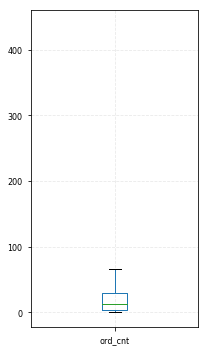

In [13]:
# outlier 확인, outlier가 맞을까?
df['ord_cnt'].plot(kind='box', figsize=(3,5))

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

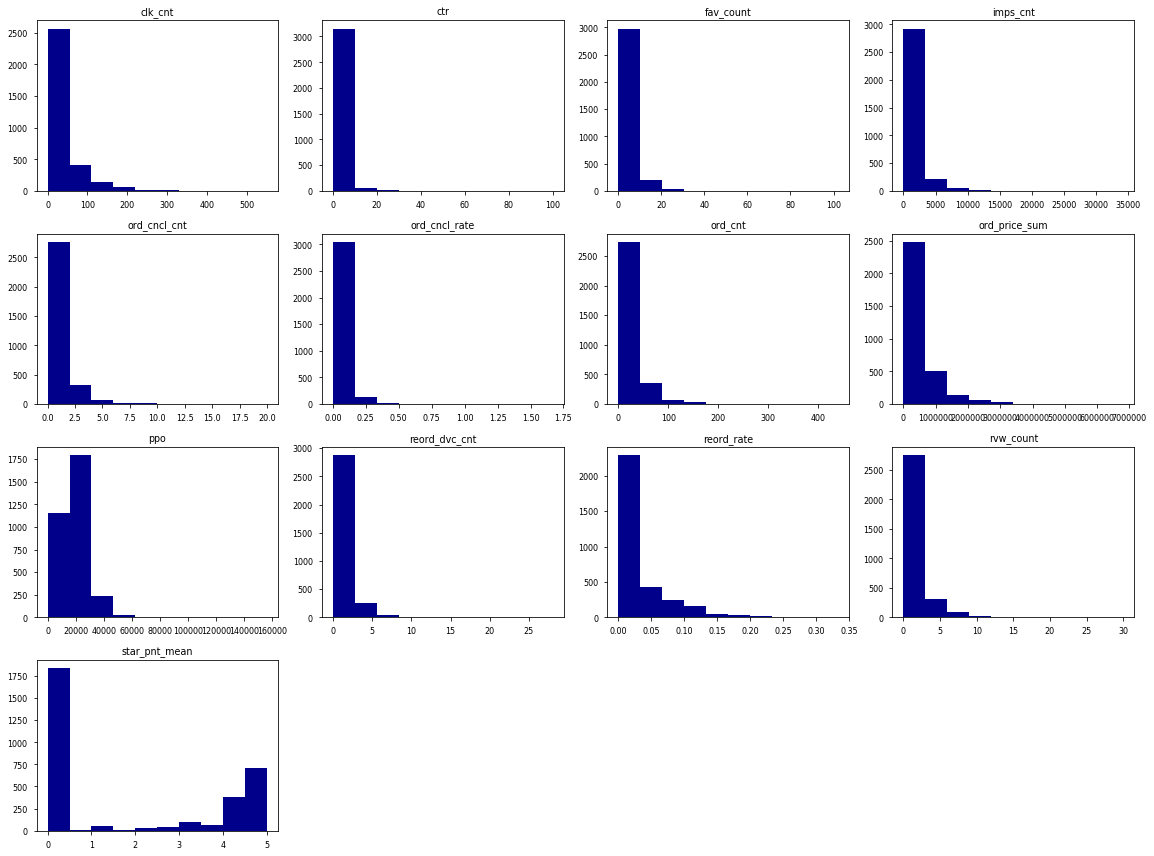

In [14]:
df.hist(color='darkblue', figsize=(16,12), grid=False);

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

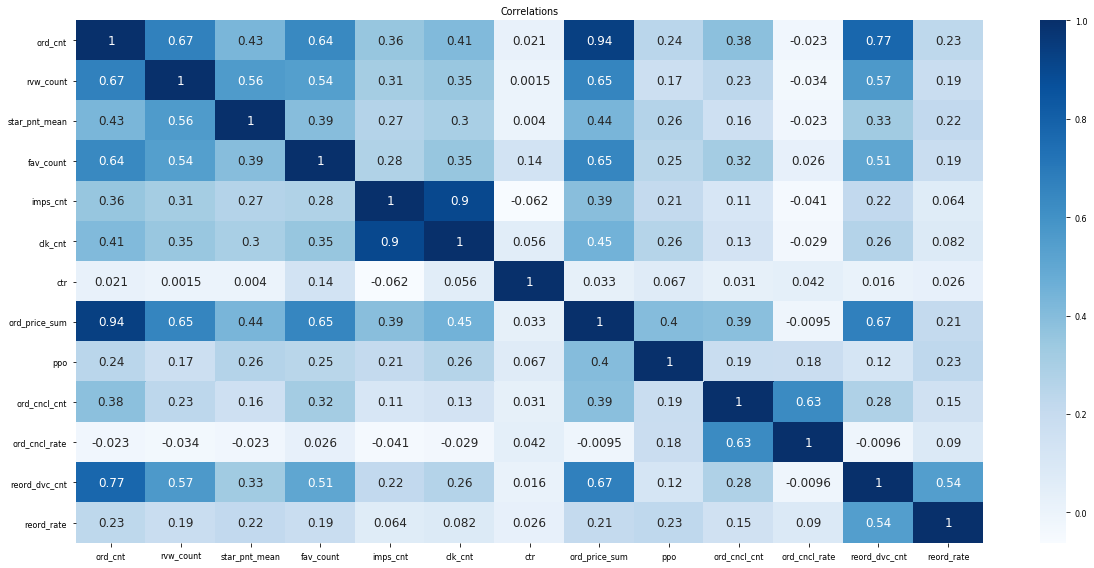

In [15]:
plt.subplots(figsize=(17,8))

sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.title("Correlations")
plt.tight_layout()

In [16]:
# drop cols
cols_to_drop = ['ord_price_sum', 'imps_cnt', 'clk_cnt', 'ord_cncl_cnt', 'reord_dvc_cnt']

df.drop(cols_to_drop, axis=1, inplace=True)

In [17]:
df.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
0,36235,관악구,2010-02-28,15.0,1.0,5.0,0.0,2.027,30533.0,0.000,0.000
1,459193,관악구,2013-01-30,61.0,1.0,5.0,6.0,2.248,16544.0,0.016,0.082
2,522695,강서구,2014-07-22,62.0,4.0,5.0,4.0,1.553,17758.0,0.016,0.000
3,563770,송파구,2015-05-13,75.0,2.0,5.0,5.0,2.159,11920.0,0.000,0.040
4,563771,송파구,2015-05-13,95.0,2.0,5.0,6.0,1.567,28426.0,0.011,0.032


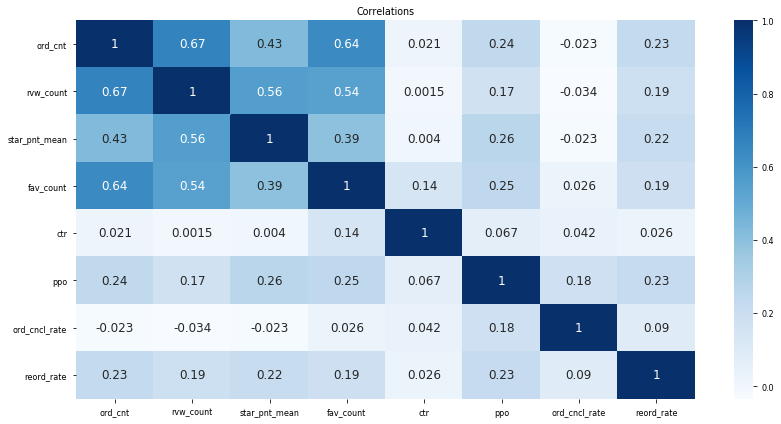

In [18]:
plt.subplots(figsize=(12,6))

sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.title("Correlations")
plt.tight_layout()

### 스코어 계산
- 단순합은 어떨까?
- 단위를 어떻게 맞출까?

In [19]:
# Scaling
from sklearn import preprocessing

scaled_array = preprocessing.MinMaxScaler().fit_transform(df.loc[:, 'ord_cnt':])
score_scaled = pd.DataFrame(scaled_array, columns=df.loc[:,'ord_cnt':].columns)

score_scaled.head(10)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
0,0.034169,0.033333,1.0,0.000000,0.02027,0.195099,0.000000,0.000000
1,0.138952,0.033333,1.0,0.058824,0.02248,0.105712,0.009598,0.246246
2,0.141230,0.133333,1.0,0.039216,0.01553,0.113470,0.009598,0.000000
3,0.170843,0.066667,1.0,0.049020,0.02159,0.076166,0.000000,0.120120
4,0.216401,0.066667,1.0,0.058824,0.01567,0.181636,0.006599,0.096096
5,0.054670,0.000000,0.0,0.019608,0.00000,0.080351,0.074985,0.126126
6,0.013667,0.000000,0.0,0.009804,0.02534,0.125661,0.000000,0.000000
7,0.022779,0.000000,0.0,0.029412,0.01606,0.263898,0.000000,0.000000
8,0.038724,0.000000,0.0,0.029412,0.04861,0.326780,0.000000,0.000000
9,0.132118,0.033333,1.0,0.068627,0.03271,0.170703,0.000000,0.051051


In [20]:
score_scaled.describe()

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
count,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000
mean,0.051717,0.038880,0.357082,0.036566,0.032313,0.106448,0.018687,0.075581
std,0.070409,0.077937,0.432341,0.047977,0.032399,0.077380,0.051961,0.127710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009112,0.000000,0.000000,0.009804,0.017090,0.000000,0.000000,0.000000
50%,0.027335,0.000000,0.000000,0.019608,0.029090,0.117936,0.000000,0.000000
75%,0.066059,0.033333,0.800000,0.049020,0.042790,0.150147,0.014397,0.129129
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df_scaled = pd.concat([df.loc[:,:'reg_dt'], score_scaled], axis=1)

df_scaled.head(10)

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate
0,36235,관악구,2010-02-28,0.034169,0.033333,1.0,0.000000,0.02027,0.195099,0.000000,0.000000
1,459193,관악구,2013-01-30,0.138952,0.033333,1.0,0.058824,0.02248,0.105712,0.009598,0.246246
2,522695,강서구,2014-07-22,0.141230,0.133333,1.0,0.039216,0.01553,0.113470,0.009598,0.000000
3,563770,송파구,2015-05-13,0.170843,0.066667,1.0,0.049020,0.02159,0.076166,0.000000,0.120120
4,563771,송파구,2015-05-13,0.216401,0.066667,1.0,0.058824,0.01567,0.181636,0.006599,0.096096
5,565209,송파구,2015-05-22,0.054670,0.000000,0.0,0.019608,0.00000,0.080351,0.074985,0.126126
6,565434,송파구,2015-05-27,0.013667,0.000000,0.0,0.009804,0.02534,0.125661,0.000000,0.000000
7,566297,송파구,2015-06-01,0.022779,0.000000,0.0,0.029412,0.01606,0.263898,0.000000,0.000000
8,566306,송파구,2015-06-01,0.038724,0.000000,0.0,0.029412,0.04861,0.326780,0.000000,0.000000
9,567009,송파구,2015-06-05,0.132118,0.033333,1.0,0.068627,0.03271,0.170703,0.000000,0.051051


In [23]:
# positive to negative 
df_scaled['ord_cncl_rate'] =  -1 * df_scaled['ord_cncl_rate']

In [24]:
df_scaled['score'] = df_scaled.sum(axis=1)

In [25]:
df_scaled.describe().round(2)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
count,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00
mean,0.05,0.04,0.36,0.04,0.03,0.11,-0.02,0.08,0.68
std,0.07,0.08,0.43,0.05,0.03,0.08,0.05,0.13,0.62
min,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,-0.63
25%,0.01,0.00,0.00,0.01,0.02,0.00,-0.01,0.00,0.11
50%,0.03,0.00,0.00,0.02,0.03,0.12,-0.00,0.00,0.44
75%,0.07,0.03,0.80,0.05,0.04,0.15,-0.00,0.13,1.26
max,1.00,1.00,1.00,1.00,1.00,1.00,-0.00,1.00,2.77


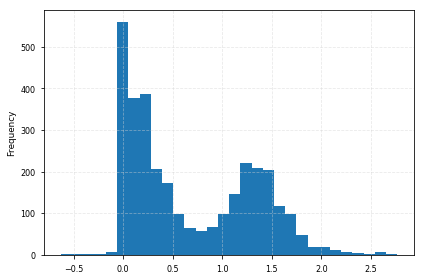

In [26]:
df_scaled['score'].plot(kind='hist', bins=30)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [36]:
## set weights
# ctr: 7
# ppo: 14
# ord_cncl_rate: 8
# reord_rate: 22

df_weight = df_scaled.drop("score", axis=1)

df_weight['ctr'] = df_weight['ctr'] * 7
df_weight['ppo'] = df_weight['ppo'] * 14
df_weight['ord_cncl_rate'] = df_weight['ord_cncl_rate'] * 8
df_weight['reord_rate'] = df_weight['reord_rate'] * 22

df_weight['score'] = df_weight.sum(axis=1)
df_weight.sort_values("score", ascending=False, inplace=True)
df_weight['rank'] = df_weight.score.rank(method='first')

In [37]:
df_weight.head(10)

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score,rank
1920,716445,성남시 분당구,2017-11-13,0.013667,0.000000,0.00,0.009804,0.29848,4.337137,-0.000000,22.000000,26.659089,3215.0
1888,715580,중구,2017-11-09,0.027335,0.033333,0.80,0.029412,0.27874,2.228192,-0.398320,22.000000,24.998691,3214.0
2219,726226,부천시,2017-12-14,0.015945,0.033333,1.00,0.058824,0.08568,2.045968,-0.000000,18.894895,22.134645,3213.0
1852,714427,동작구,2017-11-06,0.013667,0.000000,0.00,0.009804,0.15799,0.885623,-1.598080,22.000000,21.469004,3212.0
15,571725,강남구,2015-07-08,0.043280,0.000000,0.00,0.039216,0.39438,1.587591,-1.012597,17.375375,18.427245,3211.0
262,613364,강남구,2016-03-20,0.011390,0.033333,1.00,0.029412,0.00000,3.936102,-0.000000,13.213213,18.223450,3210.0
1974,718222,도봉구,2017-11-17,0.011390,0.033333,1.00,0.000000,0.13531,3.470927,-0.000000,13.213213,17.864173,3209.0
3038,743549,수원시 영통구,2018-02-20,0.020501,0.133333,0.65,0.049020,0.16527,1.765252,-0.000000,14.666667,17.450043,3208.0
1365,692685,강남구,2017-08-07,0.020501,0.000000,0.00,0.068627,0.37632,2.773163,-0.532693,14.666667,17.372585,3207.0
2763,737724,종로구,2018-01-24,0.020501,0.000000,0.00,0.000000,0.14931,2.342696,-0.000000,14.666667,17.179174,3206.0


In [38]:
df_weight.describe().round(2)

,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score,rank
count,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00,3215.00
mean,0.05,0.04,0.36,0.04,0.23,1.49,-0.15,1.66,3.71,1608.00
std,0.07,0.08,0.43,0.05,0.23,1.08,0.42,2.81,3.43,928.23
min,0.00,0.00,0.00,0.00,0.00,0.00,-8.00,0.00,-4.34,1.00
25%,0.01,0.00,0.00,0.01,0.12,0.00,-0.12,0.00,0.93,804.50
50%,0.03,0.00,0.00,0.02,0.20,1.65,-0.00,0.00,2.85,1608.00
75%,0.07,0.03,0.80,0.05,0.30,2.10,-0.00,2.84,5.65,2411.50
max,1.00,1.00,1.00,1.00,7.00,14.00,-0.00,22.00,26.66,3215.00


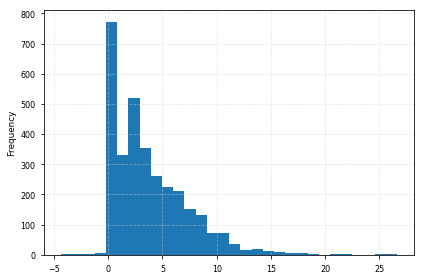

In [30]:
# 전체 지역
df_weight['score'].plot(kind='hist', bins=30)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

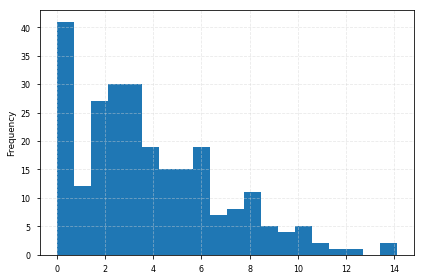

In [45]:
# 특정 지역
df_weight.query("rgn2_nm == '송파구'")['score'].plot(kind='hist', bins=20)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [30]:
df_weight.query("rgn2_nm == '송파구'")[:10]

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
52,576886,송파구,2015-08-18,0.013667,0.000000,0.000000,0.009804,0.08645,14.000000,-0.000000,0.000000,14.109921
1113,675945,송파구,2017-05-18,0.029613,0.033333,1.000000,0.000000,0.15764,2.153764,-0.000000,10.174174,13.548524
908,658146,송파구,2017-01-24,0.056948,0.000000,0.000000,0.009804,0.31199,1.198722,-0.000000,10.570571,12.148034
239,611564,송파구,2016-03-08,0.202733,0.633333,0.926316,0.107843,0.04858,1.122863,-0.105579,8.918919,11.855008
1319,689491,송파구,2017-07-20,0.015945,0.000000,0.000000,0.019608,0.28483,2.121380,-0.686263,9.447447,11.202948
10,567365,송파구,2015-06-08,0.027335,0.033333,0.800000,0.019608,0.81396,3.444089,-0.000000,5.483483,10.621809
886,656463,송파구,2017-01-12,0.054670,0.066667,0.800000,0.019608,0.06510,1.484179,-0.201560,8.258258,10.546922
820,652644,송파구,2016-12-20,0.020501,0.033333,0.200000,0.029412,0.12334,2.773163,-0.000000,7.333333,10.513083
91,594320,송파구,2015-11-24,0.095672,0.100000,1.000000,0.029412,0.18669,1.471744,-0.340732,7.861862,10.404648
2604,734362,송파구,2018-01-12,0.129841,0.200000,0.900000,0.166667,0.30261,1.564958,-0.000000,6.936937,10.201013


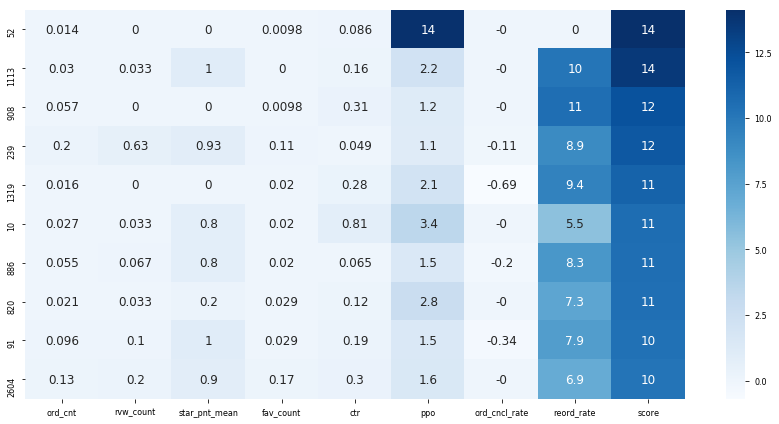

In [47]:
plt.subplots(figsize=(12,6))

sns.heatmap(df_weight.query("rgn2_nm == '송파구'").loc[:,'ord_cnt':'score'][:10], annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.tight_layout()

In [48]:
df_weight.query("rgn2_nm == '강남구'")[:10]

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score,rank
15,571725,강남구,2015-07-08,0.043280,0.000000,0.0,0.039216,0.39438,1.587591,-1.012597,17.375375,18.427245,3211.0
262,613364,강남구,2016-03-20,0.011390,0.033333,1.0,0.029412,0.00000,3.936102,-0.000000,13.213213,18.223450,3210.0
1365,692685,강남구,2017-08-07,0.020501,0.000000,0.0,0.068627,0.37632,2.773163,-0.532693,14.666667,17.372585,3207.0
2492,733019,강남구,2018-01-08,0.031891,0.000000,0.0,0.049020,0.24780,1.895770,-0.686263,14.138138,15.676356,3197.0
3015,742996,강남구,2018-02-14,0.020501,0.000000,0.0,0.039216,0.00000,1.461099,-0.532693,14.666667,15.654789,3196.0
3186,749039,강남구,2018-03-13,0.052392,0.033333,0.8,0.245098,0.64365,1.754070,-0.417516,11.495495,14.606522,3187.0
862,654670,강남구,2017-01-02,0.013667,0.000000,0.0,0.000000,0.30107,2.916294,-0.000000,11.033033,14.264064,3184.0
536,633405,강남구,2016-08-19,0.054670,0.133333,0.7,0.019608,0.18375,2.314696,-0.398320,11.033033,14.040770,3176.0
524,633050,강남구,2016-08-17,0.027335,0.033333,1.0,0.000000,0.12880,1.031706,-0.000000,11.033033,13.254207,3165.0
2975,742386,강남구,2018-02-12,0.018223,0.033333,1.0,0.039216,0.43323,3.444089,-0.000000,8.258258,13.226350,3164.0


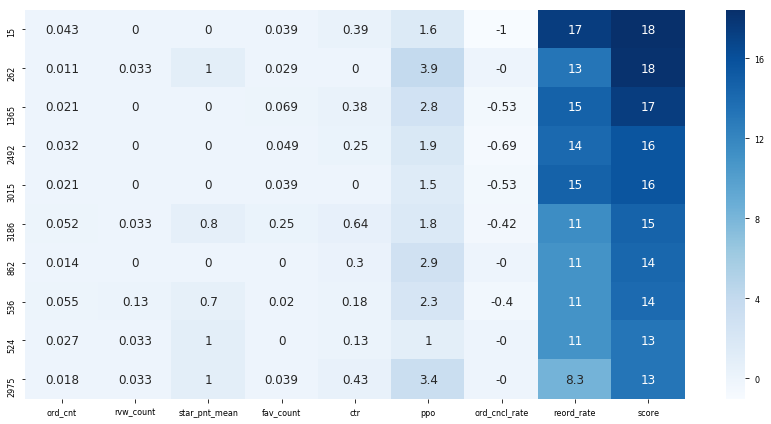

In [49]:
plt.subplots(figsize=(12,6))

sns.heatmap(df_weight.query("rgn2_nm == '강남구'").loc[:,'ord_cnt':'score'][:10], annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.tight_layout()

In [52]:
## set other weights

df_weight = df_scaled.drop("score", axis=1)

df_weight['ctr'] = df_weight['ctr'] * 2
df_weight['ppo'] = df_weight['ppo'] * 2.5
df_weight['ord_cncl_rate'] = df_weight['ord_cncl_rate'] * 3
df_weight['reord_rate'] = df_weight['reord_rate'] * 3.2

df_weight['score'] = df_weight.sum(axis=1)
df_weight.sort_values("score", ascending=False, inplace=True)
df_weight['rank'] = df_weight.score.rank(method='first')

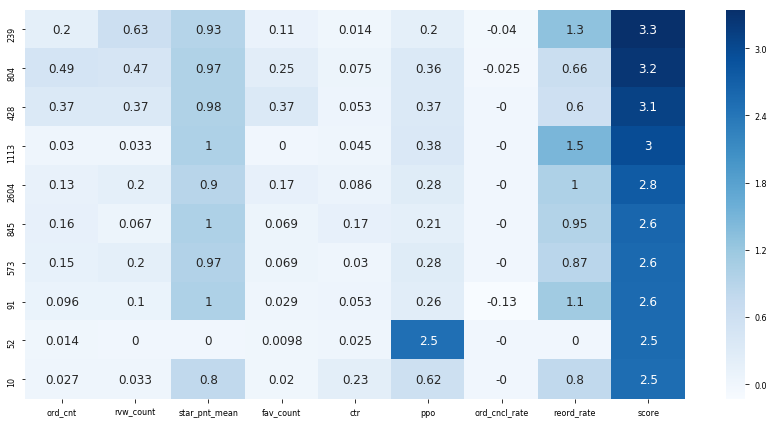

In [53]:
plt.subplots(figsize=(12,6))

sns.heatmap(df_weight.query("rgn2_nm == '송파구'").loc[:,'ord_cnt':'score'][:10], annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.tight_layout()

- 지속적으로 Build, Measure, Learn cycle with the agile process
- 특정 중요 행동이 정의됐다면? 그 행동 기준으로 coefficient 혹은 feature importance 이용
    - Domain Knowledge
- 협업
    - 데이터 엔지니어: 테이블 및 배치 작업 
    - 서버개발자: 해당 테이블 활용하여 개발
    - 기획자: 가중치 조정 및 a/b 실험 + 로직 고도화

## Collaborative Filtering

- 특정 업소 마다 추천되는 리스트가 동일하므로, 개인의 취향이 완전히 고려되지 않음
- 유사한 특성을 지닌 다른 유저가 선호하는 업소를 추천(user-based)하는 방식을 고려 (user-based)

![img](cf.png)

- user-based
    - item 정보 관련 없이 추천이 가능하며 간단한 알고리즘, but 연산량 및 cold-start 문제
- item-based
    - item 정보만 있으면 가능하지만 신규 사용자에 대한 cold-starting 문제    

- 참고자료
    - [추천 시스템의 기초- 데이터 사이언스 스쿨](https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/)
    - http://sanghyukchun.github.io/31/

In [34]:
# explict feedback
rec_shop_star = pd.read_csv("tb10_recom_star.csv").drop_duplicates()

In [35]:
rec_shop_star.head()

,mem_no,shop_no,star_pnt
0,141202002872,625561,4.0
1,141202002872,634231,1.0
2,141202002942,532483,5.0
3,141202003094,727663,5.0
4,141202003266,699023,5.0


In [36]:
rec_shop_star.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243419 entries, 0 to 247529
Data columns (total 3 columns):
mem_no      243419 non-null int64
shop_no     243419 non-null int64
star_pnt    243419 non-null float64
dtypes: float64(1), int64(2)
memory usage: 7.4 MB


In [37]:
rec_shop_star['mem_no'] = rec_shop_star['mem_no'].astype(str)
rec_shop_star['shop_no'] = rec_shop_star['shop_no'].astype(str)

In [38]:
print(rec_shop_star.shape)
print(len(rec_shop_star.mem_no.unique()))
print(len(rec_shop_star.shop_no.unique()))

(243419, 3)
202606
51577


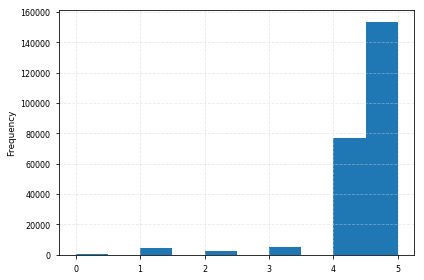

In [39]:
rec_shop_star['star_pnt'].plot(kind='hist')

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [40]:
# matrix partial
rec_shop_star[:50].pivot_table(values='star_pnt', index='mem_no', columns='shop_no', aggfunc='mean').fillna('')

shop_no,202358,396817,419467,439793,491129,514268,532483,548721,565404,570728,581036,583739,584239,587532,614551,618788,625561,627441,628081,632012,634231,643662,655058,662080,667062,677885,694523,695633,699023,702241,705530,707268,715079,716622,721620,722839,727663,7310,731653,732519,735492,735870,735909,737120,737295,738861,740278,741125,744027,746999
mem_no,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202002872,,,,,,,,,,,,,,,,,4,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202002942,,,,,,,5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202003094,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,,,,,,
141202003266,,,5,,,,,,,,,,,4,,,,,4,,,,,,,,,,5,,,,,,,,,,,,,,,,,,4,,,
141202003376,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,
141202003429,,,,,5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
141202003441,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,,,
141202003446,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,,,,,,,,,,,,,,,,,,,5,5
141202003460,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,


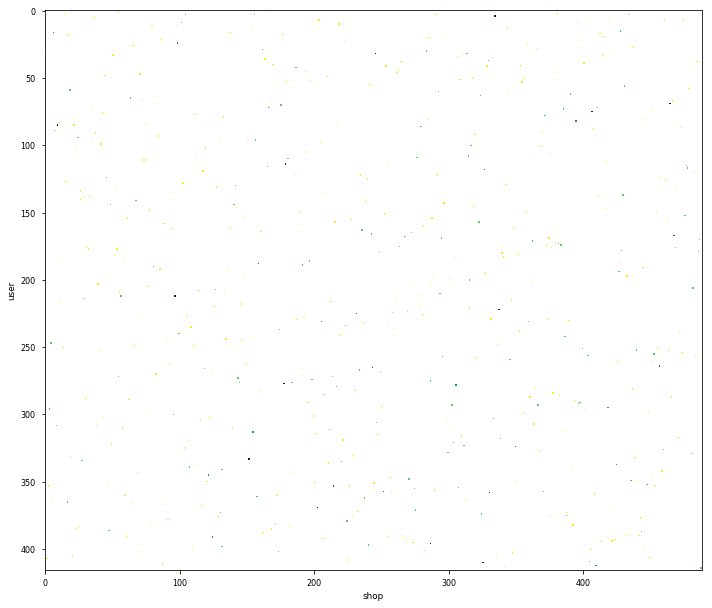

In [41]:
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(rec_shop_star[:500].pivot_table(values='star_pnt', index='mem_no', columns='shop_no', aggfunc='mean'))

plt.ylabel("user")
plt.xlabel("shop")
plt.tight_layout()
plt.show()

In [42]:
ord_mem = rec_shop_star.groupby("mem_no").size()

ord_mem.value_counts()

1      171710
2       24136
3        4818
4        1287
5         436
6         123
7          56
8          18
9           8
10          4
11          3
13          2
12          2
152         1
18          1
16          1
dtype: int64

#### Surprise Package
- How to install (http://surpriselib.com/)
- ```$ pip install scikit-surprise```
- ```conda install -c conda-forge scikit-surprise```
- How to use: https://surprise.readthedocs.io/en/stable/getting_started.html
    - API doc: http://surprise.readthedocs.io/en/stable/index.html


In [43]:
from surprise.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from surprise import Reader, Dataset, SVD, evaluate, accuracy
import surprise

reader = Reader()

In [44]:
data = Dataset.load_from_df(rec_shop_star, reader)

### Baseline model
- https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration

**STEPS**

0. train, test 준비
1. 옵션 지졍

```python
# 옵션 지정 예시1
bsl_options = {'method': 'als','n_epochs': 5, 'reg_u': 12, 'reg_i': 5}

# 옵션 지정 예시2
bsl_options = {'method': 'sgd', 'learning_rate': .00005}
```

2. 객체생성
3. k-fold 트레이닝 및 모수추정
4. 테스트셋에 평가

In [45]:
trainset, testset = train_test_split(data, test_size=.15)

In [46]:
bsl_options = {'method': 'als','n_epochs': 5, 'reg_u': 12, 'reg_i': 5}

In [47]:
baseline = surprise.BaselineOnly(bsl_options=bsl_options)

In [48]:
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):
    
    baseline.fit(trainset)
    pred = baseline.test(testset)

    print(accuracy.rmse(pred, verbose=True))

Estimating biases using als...
RMSE: 0.7470
0.7469697695899787
Estimating biases using als...
RMSE: 0.7525
0.7524512206259352
Estimating biases using als...
RMSE: 0.7661
0.7661140696930562
Estimating biases using als...
RMSE: 0.7569
0.7569086819003865
Estimating biases using als...
RMSE: 0.7590
0.759033468996812


In [49]:
pred = baseline.test(testset)

In [50]:
accuracy.rmse(pred, verbose=True)

RMSE: 0.7590


0.759033468996812

In [51]:
rec_shop_star.groupby("mem_no").size().sort_values()

mem_no
140731000016      1
171203008204      1
171203008235      1
171203008256      1
171203008303      1
171203008309      1
171203008504      1
171203008545      1
171203008561      1
171203008186      1
               ... 
201306050224     11
201401260241     11
170310000410     11
180307001938     12
180307001729     12
201405272562     13
160922003891     13
180307001985     16
151026000409     18
170929000684    152
Length: 202606, dtype: int64

In [52]:
my_mem_no = str(151026000409)

rec_shop_star.query("mem_no == @my_mem_no").sort_values("star_pnt")

,mem_no,shop_no,star_pnt
221194,151026000409,720260,1.0
221208,151026000409,743565,2.0
221200,151026000409,687753,3.0
221201,151026000409,685385,3.0
221199,151026000409,713213,3.0
221209,151026000409,731907,3.0
221196,151026000409,689148,3.0
221195,151026000409,552929,3.0
221198,151026000409,688403,4.0
221202,151026000409,688149,4.0


In [53]:
print(baseline.predict(my_mem_no, str(719536)))
print(baseline.predict(my_mem_no, str(711329)))
print(baseline.predict(my_mem_no, str(552929)))
print(baseline.predict(my_mem_no, str(720260)))

user: 151026000409 item: 719536     r_ui = None   est = 4.22   {'was_impossible': False}
user: 151026000409 item: 711329     r_ui = None   est = 4.08   {'was_impossible': False}
user: 151026000409 item: 552929     r_ui = None   est = 3.85   {'was_impossible': False}
user: 151026000409 item: 720260     r_ui = None   est = 3.52   {'was_impossible': False}


In [54]:
from sklearn.utils import shuffle

# set the condtions based on the domain
shop_list = shuffle(rec_shop_star['shop_no'].unique()).tolist()

shop_list[:10]

['749646',
 '614232',
 '736506',
 '723434',
 '707824',
 '696203',
 '585414',
 '474764',
 '716341',
 '508225']

In [55]:
def get_prediction_by_baseline(mem_no):

    # create an empty df
    predict_df = pd.DataFrame()
    
    for k, v in enumerate(shop_list[:100]):
        predict_df.loc[k,'shop_no'] = v
        predict_df.loc[k,'est_value'] = baseline.predict(mem_no, v)[3]
        predict_df['shop_no'] = predict_df['shop_no'].astype(str)

        # remove if shop_no exists
        remove = rec_shop_star[rec_shop_star['mem_no'] == mem_no][['shop_no', 'star_pnt']]
    
    predict_df = predict_df.merge(remove, on="shop_no", how="left").sort_values('est_value', ascending=False)
    
    return predict_df.fillna("unknown").query("star_pnt == 'unknown'").drop("star_pnt", axis=1)

In [56]:
get_prediction_by_baseline(str(151026000409))[:10]

,shop_no,est_value
10,719003,4.299595
65,669877,4.213598
4,707824,4.204857
2,736506,4.203985
64,685966,4.199282
26,748567,4.187801
45,685183,4.187801
66,736363,4.185253
16,715071,4.177166
53,708649,4.168645


In [57]:
get_prediction_by_baseline(str(180307001985))[:10]

,shop_no,est_value
49,691900,5.0
2,736506,5.0
53,708649,5.0
4,707824,5.0
64,685966,5.0
65,669877,5.0
26,748567,5.0
66,736363,5.0
10,719003,5.0
45,685183,5.0


### User-baesd CF

In [58]:
# 주문수 3건 이상 유저만 선택
ordcnt_by_mem = rec_shop_star.groupby("mem_no").size()

mem_list = ordcnt_by_mem[ordcnt_by_mem >= 2].reset_index()[['mem_no']]

mem_list[:10]

,mem_no
0,140731000562
1,140731000823
2,140731001115
3,140731001573
4,140731002071
5,140801000910
6,140801000984
7,140801001690
8,140801002316
9,140801002420


In [59]:
rec_shop_star1 = rec_shop_star.merge(mem_list, on='mem_no', how='inner')

In [60]:
rec_shop_star1.head()

,mem_no,shop_no,star_pnt
0,141202002872,625561,4.0
1,141202002872,634231,1.0
2,141202003266,699023,5.0
3,141202003266,628081,4.0
4,141202003266,419467,5.0


In [61]:
print(len(rec_shop_star1))

71709


In [62]:
data = Dataset.load_from_df(rec_shop_star1, reader)

In [63]:
trainset, testset = train_test_split(data, test_size=.15)

In [64]:
sim_options = {'name': 'pearson_baseline', 'user_based': True} #if user_based: False, item-based
k = 10

algo_u = surprise.KNNWithMeans(k=k, sim_options=sim_options)

In [65]:
kf = KFold(n_splits=3)

for trainset, testset in kf.split(data):
    
    algo_u.fit(trainset)
    pred = algo_u.test(testset)

    print(accuracy.rmse(pred, verbose=True))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8092
0.8091525562668125
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8240
0.8240412981504616
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8250
0.8250485160121599


In [66]:
pred = algo_u.test(testset)

In [67]:
accuracy.rmse(pred, verbose=True)

RMSE: 0.8250


0.8250485160121599

### Latent Factor Model: SVD
- http://surprise.readthedocs.io/en/latest/matrix_factorization.html

In [68]:
svd_options = {'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}

# lr_all – The learning rate for all parameters.
# reg_all – The regularization term for all parameters.

svd = surprise.SVD() 

In [69]:
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):
    
    svd.fit(trainset)
    pred = svd.test(testset)

    print(accuracy.rmse(pred, verbose=True))

RMSE: 0.7150
0.7150474306500422
RMSE: 0.7087
0.7086881242359165
RMSE: 0.7237
0.7237198162897981
RMSE: 0.7160
0.7159573397272062
RMSE: 0.7175
0.717458551104664


In [70]:
pred = svd.test(testset)

In [71]:
accuracy.rmse(pred, verbose=True)

RMSE: 0.7175


0.717458551104664

In [72]:
from sklearn.utils import shuffle

# set the condtions based on the domain
shop_list = shuffle(rec_shop_star['shop_no'].unique()).tolist()

shop_list[:10]

['662597',
 '665895',
 '710242',
 '725333',
 '435064',
 '597220',
 '505442',
 '655888',
 '675244',
 '655207']

In [73]:
def get_prediction_svd(mem_no):
    # create an empty df
    predict_df = pd.DataFrame()
    
    for k, v in enumerate(shop_list[:100]):
        predict_df.loc[k,'shop_no'] = v
        predict_df.loc[k,'est_value'] = svd.predict(mem_no, v)[3]
        predict_df['shop_no'] = predict_df['shop_no'].astype(str)        

        # remove if shop_no exists
        remove = rec_shop_star[rec_shop_star['mem_no'] == mem_no][['shop_no', 'star_pnt']]
    
    predict_df = predict_df.merge(remove, on="shop_no", how="left").sort_values('est_value', ascending=False)
    
    return predict_df.fillna("unknown").query("star_pnt == 'unknown'").drop("star_pnt", axis=1)

In [74]:
get_prediction_svd(str(151026000409))[:10]

,shop_no,est_value
60,643971,4.215732
15,673614,4.211030
40,517913,4.188944
29,687066,4.165049
77,637344,4.163739
14,744530,4.130473
6,505442,4.111747
65,661053,4.104415
92,722184,4.099689
86,741519,4.075192


In [75]:
get_prediction_svd(str(180307001985))[:10]

,shop_no,est_value
13,442482,5.000000
1,665895,5.000000
24,675054,5.000000
60,643971,4.971476
86,741519,4.962186
65,661053,4.951046
44,525632,4.931911
54,675907,4.921267
85,638355,4.919037
23,551577,4.915573


### 성과 측정
- [검색 랭킹 Evaluation](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)
    - Online Metric (based on users' interactions)
        - Click Through Rate 
        - Conversion Rate
        - Zero-result Rate
    - Offline Metric (based on relevance)
        - Average Precision
        - Precision At K
        - Mean Average Precision
        - [NDCG (Normalized Discounted Cumulative Gain)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)
- **최종 선정 지표(Metric)**
    - CTR: 클릭 / 노출 * 100
    - 주문율: 주문 / 클릭 * 100
    - 포지션별 클릭수, 주문수
    - NDCG

In [76]:
# 업소별 노출건수

metric_imp = pd.read_csv("tb7_imp_by_shop.csv").fillna(0)

In [77]:
metric_imp.head()

,log_dt,shop_no,count_sum,viewcount_sum
0,2018-04-01,703463,130.0,120.0
1,2018-04-01,669093,147.0,208.0
2,2018-04-01,612470,248.0,121.0
3,2018-04-01,752255,185.0,136.0
4,2018-04-01,627854,47.0,37.0


In [78]:
metric_imp['imp_total'] = metric_imp['count_sum'] + metric_imp['viewcount_sum'] 

In [79]:
metric_imp.groupby("log_dt")['imp_total'].sum()

log_dt
2018-04-01    485360.0
2018-04-02    257963.0
2018-04-03    264291.0
2018-04-04    250998.0
2018-04-05    390809.0
2018-04-06    385282.0
2018-04-07    425143.0
Name: imp_total, dtype: float64

In [80]:
# 업소별 클릭건수
metric_clk = pd.read_csv("tb8_clk_by_shop.csv").fillna(0)

metric_clk.head()

,log_dt,shop_no,position,clk_cnt
0,2018-04-01,744861,0,1
1,2018-04-01,707408,4,1
2,2018-04-01,739030,1,8
3,2018-04-01,730400,2,3
4,2018-04-01,644976,2,7


In [81]:
metric_clk.groupby("log_dt")['clk_cnt'].sum()

log_dt
2018-04-01    11258
2018-04-02     4917
2018-04-03     5435
2018-04-04     5156
2018-04-05     8219
2018-04-06     7904
2018-04-07    10124
Name: clk_cnt, dtype: int64

In [82]:
daily_imp = metric_imp.groupby("log_dt")['imp_total'].sum()
daily_clk = metric_clk.groupby("log_dt")['clk_cnt'].sum()

daily_metric = pd.concat([daily_imp, daily_clk], axis=1)
daily_metric

,imp_total,clk_cnt
log_dt,,
2018-04-01,485360.0,11258
2018-04-02,257963.0,4917
2018-04-03,264291.0,5435
2018-04-04,250998.0,5156
2018-04-05,390809.0,8219
2018-04-06,385282.0,7904
2018-04-07,425143.0,10124


In [83]:
daily_metric['ctr'] = (daily_metric['clk_cnt'] / daily_metric['imp_total'] * 100).round(3)

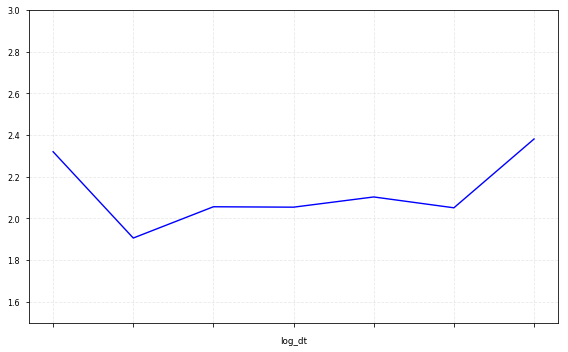

In [84]:
daily_metric['ctr'].plot(figsize=(8,5), color='blue')

plt.ylim(1.5, 3)
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

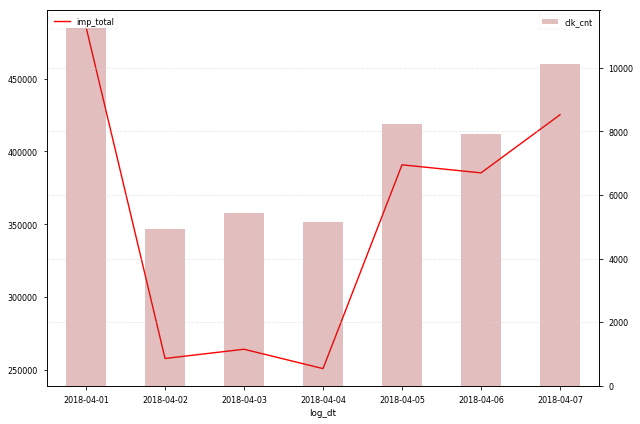

In [85]:
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111)
daily_metric['imp_total'].plot(color='red')

ax2 = ax.twinx()
daily_metric['clk_cnt'].plot(kind='bar', color='brown', alpha=0.3)

ax.legend(loc=2)
ax2.legend(loc=1)
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

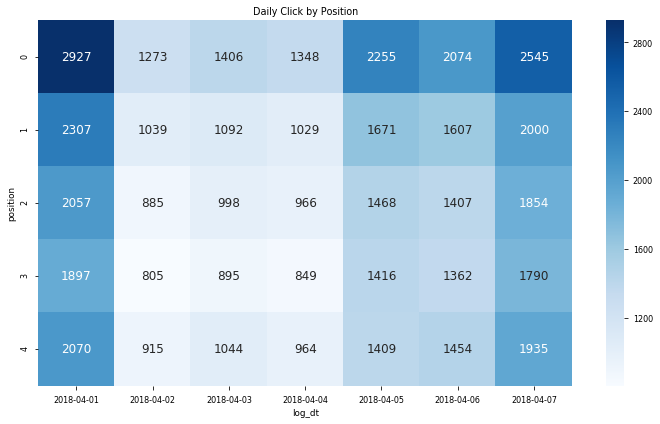

In [86]:
plt.subplots(figsize=(10,6))

sns.heatmap(metric_clk.groupby(["log_dt", "position"])['clk_cnt'].sum().unstack(level=0),\
            annot=True, annot_kws={"size": 12}, cmap='Blues', fmt='g');

plt.title("Daily Click by Position")
plt.tight_layout()

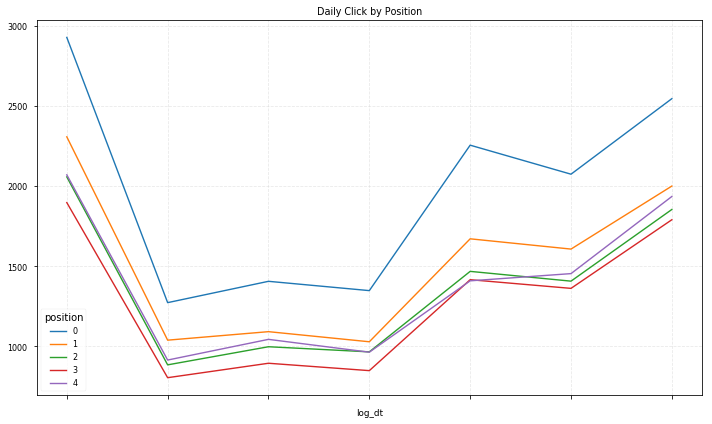

In [87]:
metric_clk.groupby(["log_dt", "position"])['clk_cnt'].sum().unstack().plot(figsize=(10,6))

plt.title("Daily Click by Position")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [88]:
## NDCG (Normalized Discounted Cumulative Gain)
# reference: https://en.wikipedia.org/wiki/Discounted_cumulative_gain)

metric_clk.head()

,log_dt,shop_no,position,clk_cnt
0,2018-04-01,744861,0,1
1,2018-04-01,707408,4,1
2,2018-04-01,739030,1,8
3,2018-04-01,730400,2,3
4,2018-04-01,644976,2,7


In [89]:
metric_clk['position_log'] = np.log2((metric_clk['position'] + 2)).round(3)

In [90]:
metric_clk.head()

,log_dt,shop_no,position,clk_cnt,position_log
0,2018-04-01,744861,0,1,1.000
1,2018-04-01,707408,4,1,2.585
2,2018-04-01,739030,1,8,1.585
3,2018-04-01,730400,2,3,2.000
4,2018-04-01,644976,2,7,2.000


In [91]:
metric_clk['clk_by_position'] = (metric_clk['clk_cnt'] / metric_clk['position_log']).round(3)

In [92]:
metric_clk.head(10)

,log_dt,shop_no,position,clk_cnt,position_log,clk_by_position
0,2018-04-01,744861,0,1,1.000,1.000
1,2018-04-01,707408,4,1,2.585,0.387
2,2018-04-01,739030,1,8,1.585,5.047
3,2018-04-01,730400,2,3,2.000,1.500
4,2018-04-01,644976,2,7,2.000,3.500
5,2018-04-01,704937,4,3,2.585,1.161
6,2018-04-01,715557,0,3,1.000,3.000
7,2018-04-01,609506,0,2,1.000,2.000
8,2018-04-02,737652,0,1,1.000,1.000
9,2018-04-02,739474,4,3,2.585,1.161


In [93]:
metric_clk.groupby("log_dt")['clk_by_position'].mean()

log_dt
2018-04-01    1.386153
2018-04-02    0.950491
2018-04-03    0.963715
2018-04-04    0.950707
2018-04-05    1.097210
2018-04-06    1.106816
2018-04-07    1.185762
Name: clk_by_position, dtype: float64

In [94]:
ndcg = metric_clk.groupby("log_dt")['clk_by_position'].describe()

ndcg

,count,mean,std,min,25%,50%,75%,max
log_dt,,,,,,,,
2018-04-01,5071.0,1.386153,1.358476,0.387,0.500,1.000,1.893,17.0
2018-04-02,3232.0,0.950491,0.757995,0.387,0.431,0.631,1.000,9.0
2018-04-03,3511.0,0.963715,0.805798,0.387,0.431,0.631,1.000,9.0
2018-04-04,3386.0,0.950707,0.774461,0.387,0.431,0.631,1.000,9.0
2018-04-05,4738.0,1.097210,0.968391,0.387,0.500,0.774,1.262,15.0
2018-04-06,4464.0,1.106816,0.983000,0.387,0.500,0.861,1.262,10.0
2018-04-07,5274.0,1.185762,1.105772,0.387,0.500,0.861,1.292,19.0


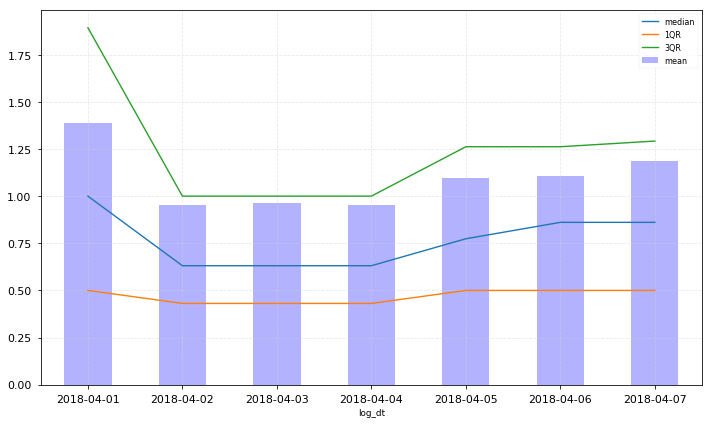

In [95]:
plt.subplots(figsize=(10,6))

ndcg['mean'].plot(label='mean', kind='bar', color='blue', alpha=.3, fontsize=11)
ndcg['50%'].plot(label='median')
ndcg['25%'].plot(label='1QR')
ndcg['75%'].plot(label='3QR')

plt.legend()
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

### Contents-based
- popularity-based 는 일괄적으로 동일한 랭크를 보여주기 때문에 개인의 취향이 고려되지 않은 단점을 지님
- CF는 cold-start 및 연산량 문제 발생
- contents(업소 태그 정보)를 이용해 업소간 유사도를 구해, **유저가 가장 선호하는 업소**와 유사한 업소를 먼저 추천해주는 방식 채택
    - 유저가 선호하는 업소 선정
        - 예) 2회 이상 주문한 업소, 5회 이상 클릭한 업소 등등
- Framework
    - 전처리 및 추출
    - 태그(컨텐츠) 이용해 가중치 tf-idf 적용 -> 매트릭스 생성
    - Cosine Similarity 도출 및 정렬
    - 유저별 선호 업소와 유사한 업소 추천

In [96]:
# 업소별 태그 정보
shop_tag = pd.read_csv("tb9_shop_tag.csv")

In [97]:
shop_tag.head()

,shop_no,rgn2_nm,content
0,575237,강남구,"디저트,커피, 디저트·커피, 달콤, 음료판매, 해쨍쨍, 집에서데이트, 비쥬얼, 밀푀..."
1,613248,강서구,"한식, 비오는날, 밥집, 매콤, 점심, 저녁, 집에서데이트, 내방, 가족식탁용, 진..."
2,616996,양천구,"한식, 사무실, 비오는날, 밥집, 국밥성애자, 점심, 들깨굴떡국, 저녁, 내방, 가..."
3,632641,서초구,"디저트·커피, 패밀리, 주말, 달콤, 음료판매, 친구들이랑, 부드러운, 집에서데이트..."
4,641984,관악구,"고기, 한식, 음료판매, 한우국밥, 회식, 저녁, 부드러운, 나들이, 육즙이흐르는,..."


In [98]:
shop_tag.tail()

,shop_no,rgn2_nm,content
5744,787681,강남구,"한식, NEW, 삼계탕, 닭도리탕"
5745,789188,강서구,NaN
5746,791217,관악구,"고기, 한식, NEW, 뼈해장국, 순대국"
5747,795129,송파구,NaN
5748,799581,용산구,NaN


In [99]:
# shops with content
shop_tag = shop_tag.dropna()

shop_tag.head()

,shop_no,rgn2_nm,content
0,575237,강남구,"디저트,커피, 디저트·커피, 달콤, 음료판매, 해쨍쨍, 집에서데이트, 비쥬얼, 밀푀..."
1,613248,강서구,"한식, 비오는날, 밥집, 매콤, 점심, 저녁, 집에서데이트, 내방, 가족식탁용, 진..."
2,616996,양천구,"한식, 사무실, 비오는날, 밥집, 국밥성애자, 점심, 들깨굴떡국, 저녁, 내방, 가..."
3,632641,서초구,"디저트·커피, 패밀리, 주말, 달콤, 음료판매, 친구들이랑, 부드러운, 집에서데이트..."
4,641984,관악구,"고기, 한식, 음료판매, 한우국밥, 회식, 저녁, 부드러운, 나들이, 육즙이흐르는,..."


In [100]:
shop_tag.tail()

,shop_no,rgn2_nm,content
5740,768540,노원구,"일식·회, 참치회, 참치초밥"
5741,771501,중랑구,"일식·회, NEW, 초밥, 회덮밥"
5742,775560,동작구,"한식, NEW, 보리새우매운탕, 한끼식사되는, 매콤, 해산물덕후, 속이풀리는, 향이..."
5744,787681,강남구,"한식, NEW, 삼계탕, 닭도리탕"
5746,791217,관악구,"고기, 한식, NEW, 뼈해장국, 순대국"


- https://blog.breezymind.com/2018/03/02/sklearn-feature_extraction-text/

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

tf = TfidfVectorizer()
# tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

tfidf_matrix = tf.fit_transform(shop_tag['content'])

### [TF-IDF](https://ko.wikipedia.org/wiki/Tf-idf)
- [Reference](https://thinkwarelab.wordpress.com/2016/11/14/ir-tf-idf-%EC%97%90-%EB%8C%80%ED%95%B4-%EC%95%8C%EC%95%84%EB%B4%85%EC%8B%9C%EB%8B%A4/)
- Term Frequency - Inverse Document Frequency)
![img](tfidf.png)

In [102]:
tfidf_matrix.toarray().shape

(5221, 7693)

In [103]:
print(tfidf_matrix.toarray())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.13880246 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [104]:
shop_tag.shape

(5221, 3)

In [105]:
for term in tf.get_feature_names():
    print (term)

100
100매운치즈돈까스
100순메밀막국수
1개
1등급한우미트볼에그베네딕트
1리터아메리카노
1월의딸기난샐러드
1인닭갈비덮밥
1인메뉴
1인벤또사이드세트
1인벤또새우튀김세트
1인보쌈도시락
1인샐러드세트
1인세트
1인족발
24시간영업
24시영업
25겹카츠일본카레덮밥
2개
2인벤또고로케세트
2인분
2인용platters풀드포크
2인피크닉세트
30cm독일수제소세지핫도그
30cm왕돈가스
3代시래기국
3가지구운버섯샐러드
3가지버섯피자
3대시래기도시락
3대째
3시래기국도시락
4가지치즈피자
4인모둠
50cm바게트브릿지
50센치바게트브릿지
5징어떡볶이
5징어짬뽕탕
742898
8090
88고추튀김
88김치삼겹두루치기
88배이컨치즈버거
88함박스테끼
88홍합짬뽕
a17스프링롤
a3특선모듬전식
azemix
a사시미
bbburger
bbq버거
bbq치즈밤
bbq포크부리또
bbq폴드포크샌드위치
bb스테이크
belt샌드위치
blt
blte샌드위치
blt샌드위치
boiledseafood
b코스
call911버거
chickenbriyani치킨비리아니
chilicheesefries
cholebhature촐레바투레
crf프라임필렛미뇽
dang
dearsophie2
gethealthy샐러드
greendetox
hola
hot오리지날밀크티
ice소금커피
is바삭모둠도시락
jin
jvl부대찌개
la갈비
la갈비구이
makhni치킨마크니
man
memphisburger
n3사천해산물팟타이
n4해산물팟타이
never롱볶이
never알감자
new
p1얇게썬홍두깨쌀국수
p2잘익힌양지쌀국수
p3잘익힌양지
plainnaan플레인난
r3파인애플새우볶음밥
r3하노이볶음밥
r8톰양볶음밥
r9숯불구이볶음밥
real자몽주스
s1해산물볶음쌀국수
s2해산물팟타이
semifive
shrimpbucket
special특모둠
spicy아마트리치아나
theboss
tov버거
tv맛집
tv맛집맛대맛
v1월남쌈
vip플러스주먹밥
火쭈꾸미
生연어회
生홍두개쌀국수
生홍두깨쌀국수
生홍두깨와양지차돌박이쌀국수
辛얼큰버섯순대국
辛쭈꾸미
가격이

멍게정식
멍석갈비
메가브리또
메가함박스테이크
메기매운탕
메기양념구이
메디오
메로
메로구이
메로소금구이
메론빙수
메리뉴욕
메리딸기
메리망고
메리초코
메리치즈
메밀국수
메밀김밥
메밀들깨수제비
메밀막국수
메밀만두
메밀물막국수
메밀부추전
메밀비빔국수
메밀비빔막국수
메밀소바
메밀전
메밀전병
메이슨자샐러드
메이플치즈핫도그
메이플허니브레드
메추리알장조림
멕시칸랩
멕시칸버거
멕시칸살사
멕시칸샐러드
멕시칸콥샐러드
멕시칸타코샌드위치
멕시칸타코샐러드
멕시칸타코칠리버거
멕시칸화이타
멕시코마요치킨
멕시코전문점
멘보샤
멜로디클렌즈
멜트치즈함박
멜티드고르곤졸라스테이크피자
멜팅치즈샌드위치
멜팅치즈파니니
면덕후
면요리
멸추김밥
멸치국밥
멸치국수
멸치김밥
멸치비빔밥
명동비빔국수
명동왕만두
명동칼국수
명란
명란고니볶음
명란구이
명란덮밥
명란두부덮밥
명란로제파스타
명란마요
명란마요밥
명란마요야끼규동
명란말이
명란바게트
명란볶음밥
명란새우덮밥
명란아보카도동
명란우삼겹덮밥
명란운동회
명란치즈계란말이
명란크림우동
명란크림파스타
명란파스타
명랑치즈카츠
명물찐만두
명물카이수산모듬사시미
명태
명태내장전골
명태맑은탕
명태매운탕
명태알찜
명태양념구이
명태조림
명태찜
명태코다리조림
명태코다리찜
명태콩나물찜
명태통살생선까스
명태회물냉면
명품곰탕
명품물회
명품오겹대패삼겹
명품찐만두
명품커리비프함박
모과차
모닝클렌저
모다기
모닥치기
모던피자
모둠보쌈
모둠사시미
모둠생선구이
모둠수육
모둠순대수육
모둠전
모둠초밥
모둠튀김
모둠회덮밥
모듬
모듬b초밥
모듬c초밥
모듬가츠
모듬감자
모듬감자튀김
모듬골뱅이탕
모듬곱창
모듬곱창볶음
모듬구이
모듬국물떡볶이
모듬꼬마김밥
모듬꼬지
모듬꼬치
모듬꼬치8종
모듬닭꼬치
모듬리완초밥
모듬만두
모듬물회
모듬물회세트
모듬미니사시미
모듬보쌈
모듬볶음밥
모듬부대찌개
모듬사리
모듬사리볶음밥
모듬사시미
모듬사시미a
모듬사시미코스
모듬생선구이
모듬생선조림
모듬생선찜
모듬세꼬시
모듬수육
모듬수육전골
모듬순대
모듬순대한접시
모듬스시
모듬오뎅꼬치
모듬오뎅탕
모듬유부쌈밥
모듬전
모듬전골
모듬전도시락
모듬족발
모듬

에그마요샌드위치
에그마요앤포테이토샌드위치
에그반미
에그번
에그베이컨샌드위치
에그베이컨샐러드
에그베이컨치즈버거
에그샌드위치
에그샐러드
에그샐러드베이글
에그쉬림프샌드위치
에그앤맛살샌드위치
에그콥샐러드
에그크로와상샌드위치
에그타르트
에그페스츄리
에그핫치킨샌드위치
에그햄치즈샌드위치
에기버거
에끌레어
에너자이저수제버거
에너지부스터
에멘탈
에멘탈치즈
에멘탈치즈감자튀김
에멘탈치즈무스
에멘탈치즈무스2호
에멘탈치즈무스케이크
에멘탈치즈케이크
에멘탈케이크
에멘탈케익
에비가츠동
에비고베카레
에비덴뿌라
에비동
에비마요
에비믹스동
에비수프카레
에비카레덮밥
에비후라이동
에스프레소큐브라떼
에이드
에이드빅사이즈
에클레어
엑스트라마르게리따
엔가와정식
엔젤쉬폰
엔칠라다
엘가전통빙수
엘리게이터
엘본스테이크
여름
여심
여자끼리
여자들끼리
여자들끼리친구들이랑
여자들이랑
역돔데리야끼동
연덕후
연어
연어구이덮밥
연어그라브락스
연어난샐러드
연어니기리
연어덮밥
연어덮밥세트
연어동
연어라임샐러드
연어롤
연어마요
연어마요덮밥
연어모듬초밥
연어뱃살
연어뱃살덮밥
연어벤또
연어불초밥
연어비빔밥
연어비트샐러드
연어사시미
연어샌드위치
연어샐러드
연어샐러디
연어세트
연어스시
연어스테이크
연어스테이크덮밥
연어스테이크샐러드
연어아보카도덮밥
연어아보카도샐러드
연어장
연어초밥
연어초밥도시락
연어컵밥
연어크림치즈김밥
연어크림치즈토스트
연어크림파스타
연어회
연어회덮밥
연어회정식
연여회
연유라떼
연유커피
연이끼리
연인끼리
연잎밥반상
연중무휴
연짬뽕
연탄고추장불고기
연탄고추장불고기도시락
연탄불고기
연탄불고기덮밥
연탄불고기도시락
연탄석쇠삼겹살
연탄초벌매운쭈꾸미
연탄초벌불닭발
연탄초벌삼겹살
연탄초벌양념꼼장어
연탄파고추장불고기
연탄파불고기
연탄파불고기도시락
연포탕
연훈제
열곰탕
열무국수
열무냉면
열무비빔냉면
열무비빔밥
열봉찜닭
열혈쭈꾸미
염통구이
영덕대게
영양갈비탕
영양삼계탕
영양소갈비찜
영양참치주먹밥
옛날고로케
옛날국물떡볶이
옛날도너츠
옛날돈가스
옛날돈까스
옛날떡볶이
옛날만두튀김
옛날불고기
옛날불고기정식
옛날수제돈까스
옛날순대
옛날왕돈까

해산물쌀국수
해산물오일파스타
해산물철판볶음밥
해산물크림파스타
해산물토마토
해산물토마토떡볶이
해산물토마토리조또
해산물토마토스튜
해산물토마토스파게티
해산물토마토오븐떡볶이
해산물토마토파스타
해산물토핑2인세트
해산물파스타
해산물팟타이
해산물팟타이누들
해삼
해삼육회
해쉬치즈버거
해쉬포테이토버거
해시브라운버거
해신탕
해온반
해장국
해장국밥
해장밥
해장벌꿀아메리카노
해쨍쟁
해쨍쨍
해쨍쩅
해천탕
해피비건
해피소고기튀김
핵마늘곱창
핵폭탄버거
핸드드립
핸드드립커피
핸드팩세트
햄가득부대찌개
햄계란후라이덮밥
햄모짜렐라샌드위치
햄반미
햄버거
햄버거스테이크
햄버거스테이크토마토파스타
햄버그빅플레이트
햄버그샌드위치
햄버그스테이크
햄샌드위치
햄소세지김치찌개
햄스페셜
햄스페셜토스트
햄앤치즈
햄앤치즈파니니
햄앤칠리치즈샌드위치
햄야채볶음밥
햄에그샌드위치
햄에그치즈샌드위치
햄치고기고기도시락
햄치아바타샌드위치
햄치즈밥버거
햄치즈베이글
햄치즈샌드
햄치즈샌드위치
햄치즈치아바타
햄치즈크로와상샌드위치
햄치즈토스트
햄치즈파니니
향라새우
향라육슬
향라육슬덮밥
향이종은
향이좋은
허니갈릭감자튀김
허니갈릭버터쉬림프
허니고구마스틱맛탕
허니고르곤졸라크라아상
허니레몬블라썸
허니리코타치즈샐러드
허니마요만두
허니명란갈릭케사디아
허니버터
허니버터브레드
허니베이컨라이스
허니부쉬블렌딩
허니브레드
허니브레드세트
허니점보토스트
허니카라멜브레드
허니큐브페스츄리
허니티
허니티라미수
허머스치킨플래터
허브닭갈비
허브돈가스
허브돈까스
허브차2잔
허브치킨카레
허브탕수육
허브튀김
헐크
헤비한메뉴
헤이즐넛아메리카노
헤이즐넛크림라떼
현미고구마버거
현미더블패티버거
현미버거
현미버섯버거
현미샐러드버거
현미수제비떡볶이
현미수제비치즈떡볶이
현미식빵
현미쌀팥빵
현미치즈버거
현지인운영
형제집모듬스페셜
혜리콤비네이션피자
호도과자
호도리롤
호두과자
호두과자10개
호두단팥고로케
호두바닐라라떼
호두타르트
호두파이
호두파이대
호두파이미니
호두호밀식빵
호떡
호미곶물회
호밀마약크림빵
호밀샌드위치
호밀토스트
호밀흑미깜파뉴
호박
호박밀크
호박빙수
호박식혜
호박죽
호안끼엠
혼

### [Cosine Similarity](http://euriion.com/?p=548)
- Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [106]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [107]:
cosine_sim.shape

(5221, 5221)

In [108]:
cosine_sim[0]

array([1.        , 0.02900407, 0.02936417, ..., 0.        , 0.        ,
       0.        ])

In [109]:
cosine_sim[2]

array([0.02936417, 0.14897867, 1.        , ..., 0.0757726 , 0.01776278,
       0.01741446])

In [110]:
shop_tag = shop_tag.reset_index()

In [111]:
shop_tag.head()

,index,shop_no,rgn2_nm,content
0,0,575237,강남구,"디저트,커피, 디저트·커피, 달콤, 음료판매, 해쨍쨍, 집에서데이트, 비쥬얼, 밀푀..."
1,1,613248,강서구,"한식, 비오는날, 밥집, 매콤, 점심, 저녁, 집에서데이트, 내방, 가족식탁용, 진..."
2,2,616996,양천구,"한식, 사무실, 비오는날, 밥집, 국밥성애자, 점심, 들깨굴떡국, 저녁, 내방, 가..."
3,3,632641,서초구,"디저트·커피, 패밀리, 주말, 달콤, 음료판매, 친구들이랑, 부드러운, 집에서데이트..."
4,4,641984,관악구,"고기, 한식, 음료판매, 한우국밥, 회식, 저녁, 부드러운, 나들이, 육즙이흐르는,..."


In [112]:
shop_no = shop_tag['shop_no']

In [113]:
indice = pd.Series(shop_no.index, index=shop_tag['shop_no'])

In [114]:
indice.head(10)

shop_no
575237    0
613248    1
616996    2
632641    3
641984    4
642919    5
682027    6
683516    7
688297    8
700945    9
dtype: int64

In [115]:
# basic simple ver1
def get_recommandations(shop_no, rgn):

    idx = indice[shop_no]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    shop_indices = [i[0] for i in sim_scores]
    
    return shop_tag.iloc[shop_indices][shop_tag['rgn2_nm'] == rgn]

In [116]:
get_recommandations(613248, "송파구")[:10]

,index,shop_no,rgn2_nm,content
3024,3322,674507,송파구,"한식, 쌀쌀할때, 밥집, 음료판매, 회식, 사시사철, 점심, 내방, 가족식탁용, 진..."
3923,4312,672402,송파구,"한식, 주말, 계란말이, 밥집, 매콤, 쌀덕후, 점심, 저녁, 유정란왕계란알말이, ..."
87,101,615301,송파구,"고기, 한식, 주말, 쌀쌀할때, 비오는날, 간장게장, 저녁에붐비는, 회식, 사시사철..."
4301,4731,678934,송파구,"고기, 한식, 주말, 친구들이랑, 매콤, 회식, 저녁, 부드러운, 내방, 진한국물,..."
4735,5207,637833,송파구,"고기, 한식, 주말, 음료판매, 친구들이랑, 닭갈비, 회식, 매콤, 저녁, 퓨전한식..."
2855,3140,610692,송파구,"한식, 매콤, 쌀덕후, 회식, 저녁, 내장탕, 동태탕, 진한국물, 속이든든한, 안주..."
3639,4004,656018,송파구,"한식, 음료판매, 매콤, 저녁, 내방, 여자들끼리, 동아리방, 푸짐한, 졸맛, 사무..."
2753,3028,587813,송파구,"고기, 한식, 육식인간, 주말, 쌀쌀할때, 겨울, 밥집, 매콤, 고기성애자, 입소문..."
4892,5383,682731,송파구,"고기, 주말, 꿀맛, 밥집, 매콤, 고기성애자, 회식, 점심, 깔끔, 저녁, 가족식..."
1939,2136,619948,송파구,"아시안, 아삭아삭, 주말, 한끼식사되는, 친구들이랑, 매콤, 파인애플볶음밥, 저녁,..."


In [117]:
## improved recomand engine
df_weight.query("rgn2_nm == '송파구'")[:10]

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
52,576886,송파구,2015-08-18,0.013667,0.000000,0.000000,0.009804,0.08645,14.000000,-0.000000,0.000000,14.109921
1113,675945,송파구,2017-05-18,0.029613,0.033333,1.000000,0.000000,0.15764,2.153764,-0.000000,10.174174,13.548524
908,658146,송파구,2017-01-24,0.056948,0.000000,0.000000,0.009804,0.31199,1.198722,-0.000000,10.570571,12.148034
239,611564,송파구,2016-03-08,0.202733,0.633333,0.926316,0.107843,0.04858,1.122863,-0.105579,8.918919,11.855008
1319,689491,송파구,2017-07-20,0.015945,0.000000,0.000000,0.019608,0.28483,2.121380,-0.686263,9.447447,11.202948
10,567365,송파구,2015-06-08,0.027335,0.033333,0.800000,0.019608,0.81396,3.444089,-0.000000,5.483483,10.621809
886,656463,송파구,2017-01-12,0.054670,0.066667,0.800000,0.019608,0.06510,1.484179,-0.201560,8.258258,10.546922
820,652644,송파구,2016-12-20,0.020501,0.033333,0.200000,0.029412,0.12334,2.773163,-0.000000,7.333333,10.513083
91,594320,송파구,2015-11-24,0.095672,0.100000,1.000000,0.029412,0.18669,1.471744,-0.340732,7.861862,10.404648
2604,734362,송파구,2018-01-12,0.129841,0.200000,0.900000,0.166667,0.30261,1.564958,-0.000000,6.936937,10.201013


In [118]:
len(df_weight.query("rgn2_nm == '송파구'"))

254

In [119]:
cutline = df_weight.query("rgn2_nm == '송파구'")['score'].quantile(0.70)

print (cutline)

5.095357411033564


In [120]:
qualified = df_weight[(df_weight['rgn2_nm'] == '송파구') & (df_weight['score'] >= cutline)]

qualified.head()

,shop_no,rgn2_nm,reg_dt,ord_cnt,rvw_count,star_pnt_mean,fav_count,ctr,ppo,ord_cncl_rate,reord_rate,score
52,576886,송파구,2015-08-18,0.013667,0.000000,0.000000,0.009804,0.08645,14.000000,-0.000000,0.000000,14.109921
1113,675945,송파구,2017-05-18,0.029613,0.033333,1.000000,0.000000,0.15764,2.153764,-0.000000,10.174174,13.548524
908,658146,송파구,2017-01-24,0.056948,0.000000,0.000000,0.009804,0.31199,1.198722,-0.000000,10.570571,12.148034
239,611564,송파구,2016-03-08,0.202733,0.633333,0.926316,0.107843,0.04858,1.122863,-0.105579,8.918919,11.855008
1319,689491,송파구,2017-07-20,0.015945,0.000000,0.000000,0.019608,0.28483,2.121380,-0.686263,9.447447,11.202948


In [121]:
# hybrid
def improved_recommandations(shop_no, rgn):

    idx = indice[shop_no]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    shop_indices = [i[0] for i in sim_scores]  
    all_shop = shop_tag.iloc[shop_indices][shop_tag['rgn2_nm'] == rgn]
    
    # qualified dataset
    cutline = df_weight[df_weight["rgn2_nm"] == rgn]['score'].quantile(0.70)
    print ("score_cutline: ", cutline)
    
    qualified = df_weight[(df_weight['rgn2_nm'] == rgn) & (df_weight['score'] >= cutline)][['shop_no']]
    qualified['shop_no'] = qualified['shop_no'].astype(int)
    qualified['flag'] = 'qualified'
    
    # merge
    qualified_shop = all_shop.merge(qualified, on='shop_no', how='left').query("flag == 'qualified'")
    
    return qualified_shop

In [122]:
# improved
improved_recommandations(613248, "송파구")[:10]

score_cutline:  5.095357411033564


,index,shop_no,rgn2_nm,content,flag
2,101,615301,송파구,"고기, 한식, 주말, 쌀쌀할때, 비오는날, 간장게장, 저녁에붐비는, 회식, 사시사철...",qualified
5,3140,610692,송파구,"한식, 매콤, 쌀덕후, 회식, 저녁, 내장탕, 동태탕, 진한국물, 속이든든한, 안주...",qualified
7,3028,587813,송파구,"고기, 한식, 육식인간, 주말, 쌀쌀할때, 겨울, 밥집, 매콤, 고기성애자, 입소문...",qualified
9,2136,619948,송파구,"아시안, 아삭아삭, 주말, 한끼식사되는, 친구들이랑, 매콤, 파인애플볶음밥, 저녁,...",qualified
15,198,672893,송파구,"고기, 육식인간, 아삭아삭, 친구들이랑, 매콤, 회식, 저녁, 퓨전한식, 부드러운,...",qualified
22,2074,615582,송파구,"분식, 한식, 고기만두, 친구들이랑, 매콤, 저녁, 참치김밥, 내방, 제육덮밥, 속...",qualified
26,3787,571280,송파구,"한식대첩, 한식, 건강보양식, 쌀쌀할때, 저녁에붐비는, 탄성자동발사, 입소문난, 우...",qualified
37,3969,689491,송파구,"아시안, 아삭아삭, 주말, 친구들이랑, 저녁, 집에서데이트, 내방, 진한국물, 비쥬...",qualified
46,5173,608953,송파구,"분식, 비오는날, 바삭바삭, 음료판매, 매콤, 순대, 사시사철, 점심, 깔끔, 세트...",qualified
48,4893,602981,송파구,"고기, 한식대첩, 동양요리, 한식, 고기사랑, 포차, 주말, 저녁에붐비는, 밥집, ...",qualified


In [123]:
# basic contents based
get_recommandations(613248, "송파구")[:10]

,index,shop_no,rgn2_nm,content
3024,3322,674507,송파구,"한식, 쌀쌀할때, 밥집, 음료판매, 회식, 사시사철, 점심, 내방, 가족식탁용, 진..."
3923,4312,672402,송파구,"한식, 주말, 계란말이, 밥집, 매콤, 쌀덕후, 점심, 저녁, 유정란왕계란알말이, ..."
87,101,615301,송파구,"고기, 한식, 주말, 쌀쌀할때, 비오는날, 간장게장, 저녁에붐비는, 회식, 사시사철..."
4301,4731,678934,송파구,"고기, 한식, 주말, 친구들이랑, 매콤, 회식, 저녁, 부드러운, 내방, 진한국물,..."
4735,5207,637833,송파구,"고기, 한식, 주말, 음료판매, 친구들이랑, 닭갈비, 회식, 매콤, 저녁, 퓨전한식..."
2855,3140,610692,송파구,"한식, 매콤, 쌀덕후, 회식, 저녁, 내장탕, 동태탕, 진한국물, 속이든든한, 안주..."
3639,4004,656018,송파구,"한식, 음료판매, 매콤, 저녁, 내방, 여자들끼리, 동아리방, 푸짐한, 졸맛, 사무..."
2753,3028,587813,송파구,"고기, 한식, 육식인간, 주말, 쌀쌀할때, 겨울, 밥집, 매콤, 고기성애자, 입소문..."
4892,5383,682731,송파구,"고기, 주말, 꿀맛, 밥집, 매콤, 고기성애자, 회식, 점심, 깔끔, 저녁, 가족식..."
1939,2136,619948,송파구,"아시안, 아삭아삭, 주말, 한끼식사되는, 친구들이랑, 매콤, 파인애플볶음밥, 저녁,..."


### 추가 고려사항
 - 반복적인 실험설계 및 지표 트래킹으로 적합한 hybrid 모델을 찾아가는 과정 필요
 - 유저 특성을 나타내는 변수를 기반으로 정확성 상승 필요
     - 주요 카테고리, 방문횟수, 재주문율, 지역, 연령 등
 - Business Rules  
 - 다양한 로직 적용후 정의한 지표 tracking

### Implicit dataset
- Latent Factor Model: SVDpp
- http://surprise.readthedocs.io/en/latest/matrix_factorization.html

In [124]:
# 주문 정보
shop_ord_tb = pd.read_csv("tb2_ord.csv")

shop_ord_tb.head()

,ord_no,shop_no,dvc_id,ord_price,ord_prog_cd,ord_dt
0,TBJSVF018963,627879,OPUD9B95F362-69E0-495A-A920-6DCC0AED5989,9000,3,2018-03-28
1,TBIUZX013748,611777,OPUD2b10ee558d42a2a6,15900,2,2018-03-28
2,TBODPL001502,705469,OPUD77DD1E51-DF1F-4E1C-8A0E-CA2FCDDD9C70,55300,2,2018-03-28
3,TBKSLN013277,645203,OPUD6b4322f7a96bb571,12500,2,2018-03-28
4,TBLBZB012571,651639,OPUDFD52FBEA-10CA-4022-B283-AFB70BA0204C,23000,2,2018-03-28


In [125]:
shop_ord_tb['shop_no'] = shop_ord_tb['shop_no'].astype(str)

In [126]:
shop_ord = shop_ord_tb.groupby(["dvc_id", "shop_no"]).size().to_frame().reset_index()
shop_ord.columns = ['dvc_id', 'shop_no', 'ord_cnt']

In [127]:
shop_ord.head()

,dvc_id,shop_no,ord_cnt
0,OPUD0006E65A-9061-41E2-A875-A05D565C27D4,594028,1
1,OPUD0006E65A-9061-41E2-A875-A05D565C27D4,675571,1
2,OPUD000C724E-748D-4D41-A339-B0CF2C931648,739179,1
3,OPUD000F5B22-F158-4A8B-B5CF-CC8A59FBCAB4,741721,1
4,OPUD0014C8C1-6D90-46FA-A88A-705657C15CCF,575522,1


In [128]:
shop_ord.ord_cnt.value_counts()

1    72818
2     3427
3      413
4       72
5       24
6        7
7        2
9        1
8        1
Name: ord_cnt, dtype: int64

In [129]:
shop_ord.dvc_id.value_counts()

OPUD19c815eb7abb5c1d                            12
OPUDcf9fbc37da47d45c                            12
OPUD60C9B3C3-879F-4F1C-A4C6-751820AD7FCA        12
OPUDF4831B6F-1518-4FED-AB3D-EFBCC362F797        12
OPUD9afb4b107768fda7                            11
OPUDAD788EFA-F67B-4DF3-A135-28993DFA585A        11
OPUD6becd5a29901ab2b                            11
OPUD898162ea21c35388                            10
OPUDc0802b25decb26e5                            10
OPUDB1D8A950-6D63-4638-AE77-59FCAD8DBA4F        10
                                                ..
OPUD9ca0c3b9a87d7365                             1
OPUDD09D445D-AECC-4385-B4FA-B2F4644CD5E1         1
OPUDa68604bda2637974                             1
OPUD3662220c16af5d9e                             1
OPUD4784a25cd916b4f3                             1
OPUD6EBEC705-167B-4A10-BAE2-4E8F8D531893         1
OPUDE3673FD1-1080-467B-A018-4500095C42BE         1
OPUDff0f7dafd3e4f58a                             1
OPUDD4DDF7DA-40F7-41F7-9037-F5F

In [130]:
from surprise.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from surprise import Reader, Dataset, SVD, evaluate, accuracy
import surprise

reader = Reader()

data = Dataset.load_from_df(shop_ord, reader)

In [131]:
#trainset, testset = train_test_split(data, test_size=.15)

svdpp_options = {'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}

# lr_all – The learning rate for all parameters.
# reg_all – The regularization term for all parameters.

svdpp = surprise.SVDpp() 

In [132]:
kf = KFold(n_splits=5)

for trainset, testset in kf.split(data):
    
    svdpp.fit(trainset)
    pred = svdpp.test(testset)

    print(accuracy.rmse(pred, verbose=True))

RMSE: 0.2906
0.290557857084332
RMSE: 0.2919
0.29185314049824507
RMSE: 0.2844
0.2844267132487987
RMSE: 0.2878
0.2877862932865584
RMSE: 0.2767
0.27671515401601016


In [133]:
pred = svdpp.test(testset)
accuracy.rmse(pred, verbose=True)

RMSE: 0.2767


0.27671515401601016

In [134]:
from sklearn.utils import shuffle

# set the condtions based on the domain
shop_list = shuffle(shop_ord['shop_no'].unique()).tolist()

def get_prediction_svdpp(dvc_id):
    # create an empty df
    predict_df = pd.DataFrame()
    
    for k, v in enumerate(shop_list[:100]):
        predict_df.loc[k,'shop_no'] = v
        predict_df.loc[k,'est_value'] = svdpp.predict(dvc_id, v)[3]
        predict_df['shop_no'] = predict_df['shop_no'].astype(str)        

        # remove if shop_no exists
        remove = shop_ord[shop_ord['dvc_id'] == dvc_id][['shop_no', 'ord_cnt']]
    
    predict_df = predict_df.merge(remove, on="shop_no", how="left").sort_values('est_value', ascending=False)
    
    return predict_df.fillna("unknown").query("ord_cnt == 'unknown'").drop("ord_cnt", axis=1)

In [135]:
get_prediction_svdpp('OPUD60C9B3C3-879F-4F1C-A4C6-751820AD7FCA')[:10]

,shop_no,est_value
24,571725,1.533594
82,714566,1.455606
34,733019,1.361895
69,749039,1.349287
40,674944,1.344769
76,707099,1.326256
62,694480,1.318537
71,719326,1.284910
20,658146,1.284405
31,674067,1.275844


In [136]:
get_prediction_svdpp('OPUDac34362522dd303')[:10]

,shop_no,est_value
24,571725,1.447544
82,714566,1.277104
32,718222,1.241421
76,707099,1.227113
34,733019,1.223418
20,658146,1.185640
40,674944,1.168478
81,734269,1.155091
19,693038,1.151886
58,640042,1.151375


### LTR (Learning To Rank)

- LightGBM Ranker
- xxx

In [137]:
!ls ml-latest-small/

README.txt  links.csv   movies.csv  ratings.csv tags.csv


In [138]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [139]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [140]:
movies.genres.str.split("|").head()

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
3                             [Comedy, Drama, Romance]
4                                             [Comedy]
Name: genres, dtype: object

In [141]:
import sklearn.preprocessing as skpp
import sklearn.feature_extraction as skfe

tokenizer = skfe.text.CountVectorizer()
genre_dummies = tokenizer.fit_transform(movies.genres.str.replace("|", "\t"))

tokenizer.get_feature_names()

['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'genres',
 'horror',
 'imax',
 'listed',
 'musical',
 'mystery',
 'no',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

In [142]:
genre_dummies = pd.DataFrame(genre_dummies.todense(), columns=tokenizer.get_feature_names())

movies = pd.concat([movies, genre_dummies.add_prefix("genre_")], axis=1)

movies.head()

,movieId,title,genres,genre_action,genre_adventure,genre_animation,genre_children,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_fantasy,genre_fi,genre_film,genre_genres,genre_horror,genre_imax,genre_listed,genre_musical,genre_mystery,genre_no,genre_noir,genre_romance,genre_sci,genre_thriller,genre_war,genre_western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
movie_ratings = ratings.groupby("movieId")["rating"].describe()
movie_ratings = movie_ratings.add_prefix("rating_").reset_index()

In [144]:
movies = movies.merge(movie_ratings)

movies.head()

,movieId,title,genres,genre_action,genre_adventure,genre_animation,genre_children,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_fantasy,genre_fi,genre_film,genre_genres,genre_horror,genre_imax,genre_listed,genre_musical,genre_mystery,genre_no,genre_noir,genre_romance,genre_sci,genre_thriller,genre_war,genre_western,rating_count,rating_mean,rating_std,rating_min,rating_25%,rating_50%,rating_75%,rating_max
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,215.0,3.920930,0.834859,0.5,3.50,4.0,4.5,5.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110.0,3.431818,0.881713,0.5,3.00,3.5,4.0,5.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,52.0,3.259615,1.054823,0.5,3.00,3.0,4.0,5.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7.0,2.357143,0.852168,1.0,1.75,3.0,3.0,3.0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49.0,3.071429,0.907148,0.5,3.00,3.0,3.5,5.0


In [145]:
movies.columns

Index(['movieId', 'title', 'genres', 'genre_action', 'genre_adventure',
       'genre_animation', 'genre_children', 'genre_comedy', 'genre_crime',
       'genre_documentary', 'genre_drama', 'genre_fantasy', 'genre_fi',
       'genre_film', 'genre_genres', 'genre_horror', 'genre_imax',
       'genre_listed', 'genre_musical', 'genre_mystery', 'genre_no',
       'genre_noir', 'genre_romance', 'genre_sci', 'genre_thriller',
       'genre_war', 'genre_western', 'rating_count', 'rating_mean',
       'rating_std', 'rating_min', 'rating_25%', 'rating_50%', 'rating_75%',
       'rating_max'],
      dtype='object')

In [146]:
feature_cols = [
    'genre_action', 'genre_adventure',
    'genre_animation', 'genre_children', 'genre_comedy', 'genre_crime',
    'genre_documentary', 'genre_drama', 'genre_fantasy', 'genre_fi',
    'genre_film', 'genre_genres', 'genre_horror', 'genre_imax',
    'genre_listed', 'genre_musical', 'genre_mystery', 'genre_no',
    'genre_noir', 'genre_romance', 'genre_sci', 'genre_thriller',
    'genre_war', 'genre_western', 'rating_count', 'rating_mean',
    'rating_min', 'rating_25%', 'rating_50%', 'rating_75%',
    'rating_max'
]
target_cols = "m1"

In [147]:
import lightgbm as lgb

model = lgb.LGBMRanker(n_estimators=100)

temp = movies.copy()

user_id =  160 # 146 #445 # 123 # 227 #
m1 = ratings[ratings.userId.eq(user_id)]["movieId"].values

temp["m1"] = temp.movieId.isin(m1).map(lambda x: 1 if x==True else 0)
temp["train_yn"] = np.random.randint(0, 2, len(temp))

train = temp[temp.train_yn.eq(1)].copy()
test = temp[temp.train_yn.eq(0)].copy()

train["group"] = np.random.randint(0, 100, len(train))
train = train.sort_values("group")

group_counts = train.group.value_counts().sort_index().values

model.fit(train[feature_cols], train[target_cols], group=group_counts)

LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
      importance_type='split', learning_rate=0.1, max_depth=-1,
      min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
      n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
      random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
      subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [170]:
train.group.value_counts().sort_index()

0     36
1     41
2     51
3     53
4     49
5     47
6     37
7     45
8     43
9     47
      ..
90    41
91    52
92    56
93    60
94    44
95    38
96    47
97    41
98    46
99    45
Name: group, Length: 100, dtype: int64

In [148]:
train["pred_score"] = model.predict(train[feature_cols])
test["pred_score"] = model.predict(test[feature_cols])

In [149]:
train.sort_values("pred_score", ascending=False)[["title", "genres", "m1", "pred_score"]].head(10)

,title,genres,m1,pred_score
2224,Fight Club (1999),Action|Crime|Drama|Thriller,1,1.844602
910,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1,1.810216
659,"Godfather, The (1972)",Crime|Drama,1,1.796943
418,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,1,1.762529
899,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,1,1.751421
615,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,1,1.745502
897,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,1,1.729646
334,Speed (1994),Action|Romance|Thriller,1,1.728108
546,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,1,1.720300
507,Terminator 2: Judgment Day (1991),Action|Sci-Fi,1,1.707690


In [150]:
test.sort_values("pred_score", ascending=False)[["title", "genres", "m1", "pred_score"]].head(10)

,title,genres,m1,pred_score
509,Batman (1989),Action|Crime|Thriller,1,1.761916
1938,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1,1.741095
224,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1,1.729646
31,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,1,1.715445
1502,Saving Private Ryan (1998),Action|Drama|War,1,1.711977
3633,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,1,1.690490
510,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1,1.688794
97,Braveheart (1995),Action|Drama|War,1,1.656152
257,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1,1.610205
4791,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,1,1.604983


### MAB (Multi Armed Bandit)

In [151]:
import random
import math
from scipy.stats import beta, bernoulli

In [152]:
# Importing the dataset
dataset = pd.read_csv('Ads_Optimisation.csv')

In [153]:
dataset.head(10)

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0
7,1,1,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0


In [154]:
print (len(dataset)) # trial number

10000


In [155]:
dataset.sum().reset_index(drop=True)

0    1703
1    1295
2     728
3    1196
4    2695
5     126
6    1112
7    2091
8     952
9     489
dtype: int64

In [156]:
# Random Selection

N = 10000 # trial
d = 10 # ad number

ads_selected = []
total_reward = 0

for n in range(0, N):
    ad = random.randrange(d) # one random ad
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    total_reward = total_reward + reward

In [157]:
print(total_reward)

1235


In [158]:
pd.Series(ads_selected).tail(2000).value_counts()

4    237
5    225
8    218
1    209
9    197
7    194
0    188
2    181
6    176
3    175
dtype: int64

### e-greedy

In [159]:
N = 10000 # trial
d = 10 # ad number

ads_selected = []
total_reward = 0
numbers_of_selections = [1] * d
sums_of_reward = [1] * d
average_reward = []

# parameter
eps = 0.1

for n in range(0, N):
    # flip the coin
    if bernoulli.rvs(eps, size=1)[0] == 0: # explore
        ad = random.randrange(d)
        ads_selected.append(ad)
        reward = dataset.values[n, ad]
        numbers_of_selections[ad] += 1
        sums_of_reward[ad] += reward
        total_reward += reward
                
# exploit
for i in range(0, d):
    average_reward.append(sums_of_reward[i] / numbers_of_selections[i])
    mean_best_ad = pd.Series(average_reward).sort_values(ascending=False).index[0]
    rest_n = n - len(ads_selected)
    rest_reward = dataset.values[rest_n:, mean_best_ad].sum()

final_reward = total_reward + rest_reward

In [160]:
print(final_reward)

3503


In [161]:
pd.Series(ads_selected).head(2000).value_counts()

8    230
9    212
4    209
0    209
5    200
3    197
6    196
1    196
2    187
7    164
dtype: int64

In [162]:
print(len(ads_selected))
print(rest_n)
print(mean_best_ad)

8978
1021
4


### Upper Confidence Bound
- https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/

In [163]:
# Implementing UCB

N = 10000 # trial
d = 10 # ad number

ads_selected = []
numbers_of_selections = [0] * d
sums_of_reward = [0] * d
total_reward = 0

In [164]:
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_reward[i] / numbers_of_selections[i]
            delta_i = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)
    numbers_of_selections[ad] += 1
    reward = dataset.values[n, ad]
    sums_of_reward[ad] += reward
    total_reward += reward

In [165]:
print(total_reward)

2125


In [166]:
pd.Series(ads_selected).head(2000).value_counts()

4    547
7    313
0    216
3    163
8    156
1    156
6    134
2    122
9    105
5     88
dtype: int64

### Thompson Sampling

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
- https://github.com/chris-chris/bandits-baseline/blob/master/beta.py

banner1: [0.74814855]
banner2: [0.20756982]
banner3: [0.62526507]


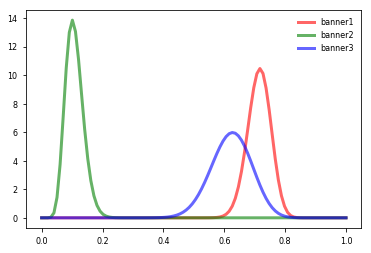

In [167]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(0, 1, 100)

## a,b param setting
# the first postion: click
# the second position: no click
ck_1, nock_1 = 100, 40
ck_2, nock_2 = 12, 99
ck_3, nock_3 = 33, 20

ax.plot(x, beta.pdf(x, ck_1, nock_1), 'r-', lw=3, alpha=0.6, label='banner1')
ax.plot(x, beta.pdf(x, ck_2, nock_2), 'g-', lw=3, alpha=0.6, label='banner2')
ax.plot(x, beta.pdf(x, ck_3, nock_3), 'b-', lw=3, alpha=0.6, label='banner3')

banner1_rvs = beta.rvs(ck_1, nock_1, size=1)
banner2_rvs = beta.rvs(ck_2, nock_2, size=1)
banner3_rvs = beta.rvs(ck_3, nock_3, size=1)

print("banner1:", banner1_rvs)
print("banner2:", banner2_rvs)
print("banner3:", banner3_rvs)

ax.plot(banner1_rvs, 0, 'x', color='red')
ax.plot(banner2_rvs, 0, 'x', color='green')
ax.plot(banner3_rvs, 0, 'x', color='blue')

ax.legend(loc='best', frameon=False)
plt.show()

### AB Testing 및 사전/사후 설문

**1. A/B 테스트 정의**
    - 임의적인 방식으로 사용자를 분류하고 각각 다른 자극/정보를 제공한 후, 사용자의 반응을 테스트하여 서비스를 개선 
    - 기획자가 시나리오 1안과 2안을 가지고 있는데 두 개중 어떤 안이 더 효과적일지 모르겠다고 해보자.
    - 그렇다면 사용자를 임의로 두 그룹으로 나누고 한 그룹에는 1안을, 다른 한 그룹에는 2안을 보여주고 사용성을 파악하여 최종안을 결정할 수 있다. 
![img](abtest_def.png)

**2. 사용자를 임의적인(Randomized) 방식으로 분류하는 것이 포인트**
    - 원인과 결과의 관계, 즉 인과관계를 명확히 규명해야 하는 실험 설계에서 가장 중요한 것은 외부요인을 완벽히 제거하는 것이다.
    - 예를 들어, 마케팅팀에서 프로모션 A방식과 B방식의 결제율 차이를 파악하려고 한다고 해보자. 그런데 한 그룹에는 20대 사용자를, 다른 그룹에는 50대 사용자를 배정한다면?
    - 이런 경우 그룹 간 결제율의 차이가 프로모션 방식으로 인한 결과라고 주장하기 어렵게 된다. (연령에 의한 차이라고 봐도 무방하기 때문이다)
    - 따라서 임의적으로 사용자를 그룹에 배정해, 연령과 같은 불필요한 외부요인을 사전에 모두 통제해야 한다.

**3. 충분한 샘플 수(Observations) 확보와 일반화(Generalization) 가능성을 반드시 고려해야**
    - 전체 사용자가 아닌 일부의 사용자를 대상으로 테스트를 진행하는 경우가 많다.
    - 그렇다면, 모든 사용자(새로운 유입될 사용자 포함)를 대상으로 일관적인 결과가 나타날 것인지 어떻게 확신할 수 있을까?
    - 한 실험의 결과가 우연으로 발생한 것이 아닌, 쉽게 바뀌지 않을(Robust) 결과라는 것을 확인하기 위해 가능한 많은 샘플 수를 확보하고 T-test, ANOVA 등 통계적 분석방법을 실행해야 한다.

**4. A/B 테스트 시행 방법**
    - A/B 테스트 발의
        - 테스트 목적 및 배경을 논의
        - 예상 일정에 대해 협의
    - 로그 정의/설계
        - 로그 화면 및 이벤트, 액션 등에 대해 정의
    - 모듈 적용 및 개발
        - 서비스에 모듈을 적용하고 필요시 개발을 진행
    - A/B 테스트 진행
        - 테스트를 진행하고 상황을 모니터링
    - 데이터를 수집 및 처리
    - 분석 및 주요 결과 공유
    - 필요시 위 사이클 반복

**5. 기대 효과 및 한계점**
    - 과학적인 의사결정 방식: 직감에 의존한 의사결정은 매번 성공적인 결과를 보장해주지 않는다. 소비자의 행동과 그로 인한 결과(데이터)에 근거해 의사결정을 할 경우 서비스의 성공 가능성을 높일 수 있다.또한 잘못된 의사결정으로 인한 금전적/시간적 손해를 줄일 수 있고, 소비자의 서비즈 만족도를 높이기 위한 기반을 마련해줄 수 있다.
    - 결과에 대한 원인을 깊이 있게 알기 어려움. A/B 테스트는 설계된 범위 안에서 특정하게 원하는 결과만을 도출할 수 있다. 예를 들어, A가 B 보다 낫다는 식의 단순한 결과만을 말해준다. 왜 A가 더 나은지 그 이유는 직접 물어보지 않는 한 명확히 알 수 없다. (사실 직접 물어볼 수 있다해도 진실을 말해줄 것이라는 보장은 없다)
    - 성공적인 A/B 테스트를 보장하는 요소: 거창한 목적과 완벽한 준비에 에너지를 쏟는 것이 아니라, 작고 빠르게 여러번 반복하면서 프로세스 및 서비스를 개선하는 것이 효과적일 것이다.